In [1]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from operator import itemgetter
import numpy as np
import scipy.stats as stats
import rioxarray as rioxr
from rasterio.enums import Resampling
import pytz

from metloom.pointdata import SnotelPointData, MesowestPointData
import datetime as dt
import matplotlib.pyplot as plt
from metloom.variables import SnotelVariables, SensorDescription, MesowestVariables
import shapely
import contextily as cx
import seaborn as sns 

import requests
import json
from dataretrieval import nwis

import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
# used this to access the metadata for CO mesowest stations
# response = requests.get('https://api.synopticdata.com/v2/stations/metadata?&token=bd62c79f64c9433daf0f2f23a0bc1f7e&output=json&state=CO').text

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# set crs for analysis
epsg_co = 32613
# Get UCRB stations
ucrb_hcdn_stations = gpd.read_file('../data/geodata/ucrb_hcdn_merged_gages.geojson')
ucrb_hcdn_stations = ucrb_hcdn_stations.to_crs(epsg_co)
# Get SNTL stations
ucrb_snotel_stations = gpd.read_file('../data/geodata/ucrb_hcdn_snotels.geojson')
ucrb_snotel_stations = ucrb_snotel_stations.to_crs(epsg_co)
# Get HCDN Basin polygons
ucrb_hcdn_basin_polygons = gpd.read_file('../data/geodata/hcdn_all_basin_polygons.geojson')
ucrb_hcdn_basin_polygons = ucrb_hcdn_basin_polygons.drop('index_right',axis=1)
ucrb_hcdn_basin_polygons = ucrb_hcdn_basin_polygons.to_crs(epsg_co)

In [4]:
# Initialized empty list
basin_gage_list = list()
# Iterate through HCDN stations
for i in ucrb_hcdn_stations.index:
    # Find all polygons that contain the station
    idx = ucrb_hcdn_basin_polygons.contains(ucrb_hcdn_stations.geometry.iloc[i]).values
    # set variable to basin geometry
    polygon = ucrb_hcdn_basin_polygons.geometry.loc[idx]
    # set variabile to point geometry
    point = ucrb_hcdn_stations.geometry.iloc[i]
    # set variable for gage name
    name = ucrb_hcdn_stations.STANAME.iloc[i]
    # set variable for gage ID
    gage = '0' + str(ucrb_hcdn_stations.STAID.iloc[i])
    # set variable for drainage area
    area = ucrb_hcdn_stations.DRAIN_SQKM.iloc[i]
    # Iterate through polygons (if necessary)
    # could see if checking if iteration is necessary for certain setups...
    for j in polygon.index:
        # append dictionary of values to list for concatentation
        basin_gage_list.append(dict(
                                    gage=gage,
                                    geom=polygon.loc[j],
                                    point=point,
                                    name=name,
                                    area=area,
                                    basin_area = polygon.loc[j].area
                                ))
# create gdf for basins and stations                                
basin_gdf = gpd.GeoDataFrame(basin_gage_list).set_geometry('geom')
station_gdf = gpd.GeoDataFrame(basin_gage_list).set_geometry('point')                           

In [5]:
# find stations within buffer 
# set buffer radius to 30 km
buff = 30000
# create buffered geomtery
basin_gdf['buffer'] = basin_gdf.centroid.buffer(buff)
basin_buffer_gdf = basin_gdf.set_geometry('buffer')
basin_buffer_gdf = basin_buffer_gdf.set_crs(epsg_co)
# spatial join for buffers containing snotel sites
basin_nearby_snotels = gpd.sjoin(basin_buffer_gdf, ucrb_snotel_stations[['site_name','site_id','geometry']], how='left',predicate='contains')
# spatial join for nearest snotel to buffer.
basin_nearest_snotels = gpd.sjoin_nearest(basin_buffer_gdf, ucrb_snotel_stations[['site_name','site_id','geometry']], how='left')

### Add basin weights... where d station is the distance from each station to the centroid of the basin and MAXD is the maximum buffer distance
$$ w_{ij} = [1- (\frac{d_{sta}}{MAXD})^3]^3$$

In [57]:
# Create empty list for buffered snotels
snotel_buffered_list = []
snotel_list = []
# columns I want to use
cols = ['gage','geom','point','name','area','basin_area','buffer']
# Iterate over gages to get unique locations
for gage in basin_nearby_snotels['gage'].unique():
    # get a list of snotel ids for gage
    id_in_buffer = basin_nearby_snotels[basin_nearby_snotels['gage']==gage].site_id.dropna().to_list()
    # add each unique snotel to list for later use
    for id in id_in_buffer:
        if id not in snotel_list:
            snotel_list.append(id)
    # get a list of snotel names for gage
    name_in_buffer = basin_nearby_snotels[basin_nearby_snotels['gage']==gage].site_name.dropna().to_list()
    # grab the nearest snotel spatially if no locations are present.
    if len(id_in_buffer) == 0:
        id_in_buffer = basin_nearest_snotels[basin_nearest_snotels['gage']==gage].site_id.dropna().to_list()
        name_in_buffer = basin_nearest_snotels[basin_nearest_snotels['gage']==gage].site_name.dropna().to_list()
    # count the number of snotels in or near each buffer
    snotel_count = len(id_in_buffer)
    # create temporary series to concatenate on and add in snotel info
    tmp_Series = basin_nearby_snotels[basin_nearby_snotels['gage']==gage].iloc[0][cols]
    tmp_Series['snotel_ids'] = id_in_buffer
    tmp_Series['snotel_names'] = name_in_buffer
    tmp_Series['snotel_count'] = snotel_count
    snotel_buffered_list.append(tmp_Series)
# build dataframe with basin geometry, gage geometry, and snotel site list
basin_station_sntl_gdf = gpd.GeoDataFrame(snotel_buffered_list)

### Import HCDN Gaging stations and data

In [7]:
# variable for station ids
station_ids = basin_station_sntl_gdf['gage']
print(f'We are working with {len(station_ids)} stations to start...')

# Run this once and then save the file, so this sequence is commented out
# hcdn_streamflow_df = nwis.get_dv(sites=station_ids, start='1900-10-01', end='2022-09-30')
# hcdn_streamflow_df[0]['00060_Mean'].reset_index().to_csv('../data/streamflowdata/ucrb_hcdn_streamflow.csv')


We are working with 37 stations to start...


In [8]:
# Now after running that datagrabber, we can just load this in
df = pd.read_csv('../data/streamflowdata/ucrb_hcdn_streamflow.csv', index_col=0)
# set a threshold end date for when the gage was taken offline
last_end_date = dt.datetime(2020, 10, 1, 0, 0, 0, 0, tzinfo=pytz.UTC)

# dictionary to hold gage info
gage_info_dict = dict()
# list to hold stations that will be dropped from the analysis due to incomplete records
stations_to_drop = []
for site in df['site_no'].unique():
    series_len = len(df[df['site_no']==site])/365
    series_start = pd.to_datetime(df[df['site_no']==site]['datetime'].iloc[0])
    series_end = pd.to_datetime(df[df['site_no']==site]['datetime'].iloc[-1])
    if (series_len > 30) & (series_end > last_end_date):
        gage_info_dict[site] = [series_len,series_start,series_end]
    else:
        stations_to_drop.append(site)
station_info = pd.DataFrame(gage_info_dict).T.rename(columns={0:'years_active', 1:'start',2:'end'})
print(f'We now have {len(station_info)} stations and dropped {len(stations_to_drop)} due to incomplete records...')

We now have 29 stations and dropped 8 due to incomplete records...


### With filtering complete, I will now drop the basins without appropriate streamflow records from the analysis

In [10]:
# filter out gage data
q_df_filtered = df[df['site_no'].isin(station_info.index)]
# filter out basins
basin_station_sntl_gdf_filtered = basin_station_sntl_gdf[basin_station_sntl_gdf['gage'].isin(['0'+str(idx) for idx in station_info.index])]
# reorder to match our q_df dataframe
basin_station_sntl_gdf_filtered = basin_station_sntl_gdf_filtered.set_index('gage').loc[['0'+str(idx) for idx in station_info.index]]

# save file of basins for future use
# basin_station_sntl_gdf_filtered[['name','basin_area','snotel_count','geometry']].set_geometry('geometry').to_file('../data/geodata/basin_station_sntl.json', driver='GeoJSON')

In [11]:
# filter dataframe to stations with long enough records
q_df_filtered = df[df['site_no'].isin(station_info.index)]

# get date of each record
dates=[d.date() for d in pd.to_datetime(q_df_filtered['datetime'])]

# Adjust this value to datetime and set index
q_df_filtered = q_df_filtered.drop(columns=['datetime'])
q_df_filtered['date'] = pd.to_datetime(dates)
q_df_filtered = q_df_filtered.set_index(['site_no','date'])

# convert units to cubic meters per day
cubic_feet_2_meters = 0.0283168
cfs_2_cmd =  3600 * 24 * cubic_feet_2_meters
q_df_filtered['00060_Mean'] = q_df_filtered['00060_Mean'] * cfs_2_cmd
# convert to an xarray dataset
hcdn_q_ds = q_df_filtered.to_xarray()
hcdn_q_ds['WY'] = hcdn_q_ds.date.dt.year.where(hcdn_q_ds.date.dt.month<10, hcdn_q_ds.date.dt.year+1)

# save to file for use in other notebooks if necessary
# hcdn_q_ds.to_netcdf('../data/streamflowdata/hcdn_q_data.nc')

In [12]:
# Only pull years with greater than 350 days of data
DATE_THRESHOLD = 350
ds = hcdn_q_ds.groupby('WY').count()

# Get total flow for each water year
hcdn_q_sum_ds = hcdn_q_ds.groupby('WY').sum(skipna=False)
hcdn_q_sum_ds_filtered = hcdn_q_sum_ds.where(ds['00060_Mean']>DATE_THRESHOLD)

# Get AMJJ flow total for each year
hcdn_q_AMJJ_ds = hcdn_q_ds.where(hcdn_q_ds.date.dt.month.isin([4,5,6,7]))
hcdn_q_AMJJ_sum_ds = (hcdn_q_AMJJ_ds).groupby('WY').sum(skipna=False) 
hcdn_q_AMJJ_sum_ds_filtered = hcdn_q_AMJJ_sum_ds.where(ds['00060_Mean']>DATE_THRESHOLD)
# Get AMJJAS flow total for each year
hcdn_q_AMJJAS_ds = hcdn_q_ds.where(hcdn_q_ds.date.dt.month.isin([4,5,6,7,8,9]))
hcdn_q_AMJJAS_sum_ds = (hcdn_q_AMJJAS_ds).groupby('WY').sum(skipna=False) 
hcdn_q_AMJJAS_sum_ds_filtered = hcdn_q_AMJJAS_sum_ds.where(ds['00060_Mean']>DATE_THRESHOLD)

In [13]:
# Calculate flow fractions for each period over eahc year
AMJJ_flow_fraction = (hcdn_q_AMJJ_sum_ds_filtered/hcdn_q_sum_ds_filtered).to_dataframe().reset_index()
AMJJAS_flow_fraction = (hcdn_q_AMJJAS_sum_ds_filtered/hcdn_q_sum_ds_filtered).to_dataframe().reset_index()

# Add filter for bad years
MINFRAC = 0.2
MAXFRAC = 0.98
# Filter the flow fractions
AMJJ_flow_fraction_filtered = AMJJ_flow_fraction.where((AMJJ_flow_fraction['00060_Mean'] > MINFRAC) & (AMJJ_flow_fraction['00060_Mean'] < MAXFRAC))
AMJJAS_flow_fraction_filtered = AMJJAS_flow_fraction.where((AMJJAS_flow_fraction['00060_Mean'] > MINFRAC) & (AMJJAS_flow_fraction['00060_Mean'] < MAXFRAC))

(0.0, 1.0)

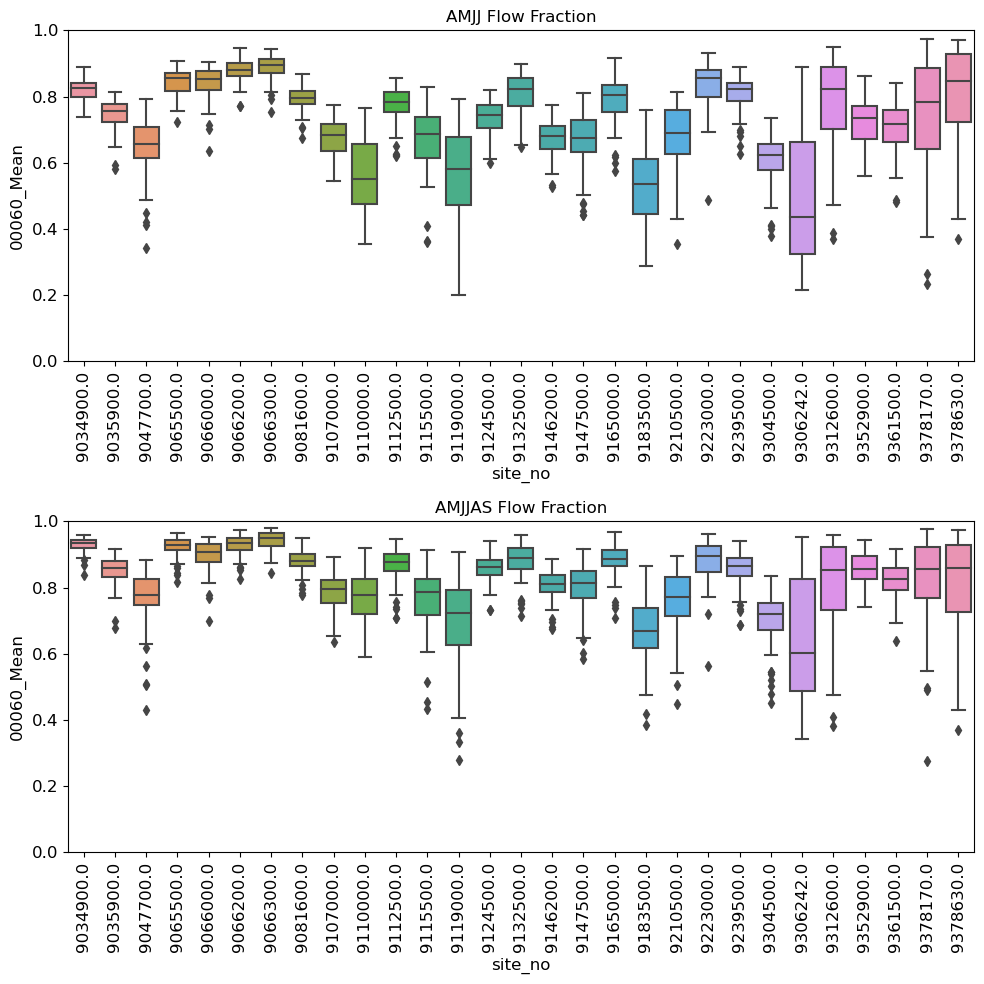

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10), tight_layout=True)
g = sns.boxplot(ax=axs[0], data=AMJJ_flow_fraction_filtered, x='site_no', y='00060_Mean')
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=90);
axs[0].set_title('AMJJ Flow Fraction')
axs[0].set_ylim(0,1)

g = sns.boxplot(ax=axs[1], data=AMJJAS_flow_fraction_filtered, x='site_no', y='00060_Mean')
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=90);
axs[1].set_title('AMJJAS Flow Fraction')
axs[1].set_ylim(0,1)

### Spatial plot of flow fractions 

In [15]:
station_elevations_df = basin_station_sntl_gdf_filtered.set_geometry('point').set_crs(epsg_co).to_crs(4326)
station_elevations_df['lon'] = station_elevations_df.point.centroid.x
station_elevations_df['lat'] = station_elevations_df.point.centroid.y 

/tmp/ipykernel_29082/3129468142.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station_elevations_df['lon'] = station_elevations_df.point.centroid.x
/tmp/ipykernel_29082/3129468142.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station_elevations_df['lat'] = station_elevations_df.point.centroid.y


In [16]:
import urllib
import urllib3
import time

# USGS Elevation Point Query Service
#url = r'https://nationalmap.gov/epqs/pqs.php?'
#new 2023:
url = r'https://epqs.nationalmap.gov/v1/json?'
def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):
                
        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        #elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        #new 2023:
        elevations.append(result.json()['value'])

    df['elev_meters'] = elevations
elevation_function(station_elevations_df, 'lat', 'lon')

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


(-56067.5341928298, 462169.4132199292, 4118161.6868092995, 4731655.471356967)

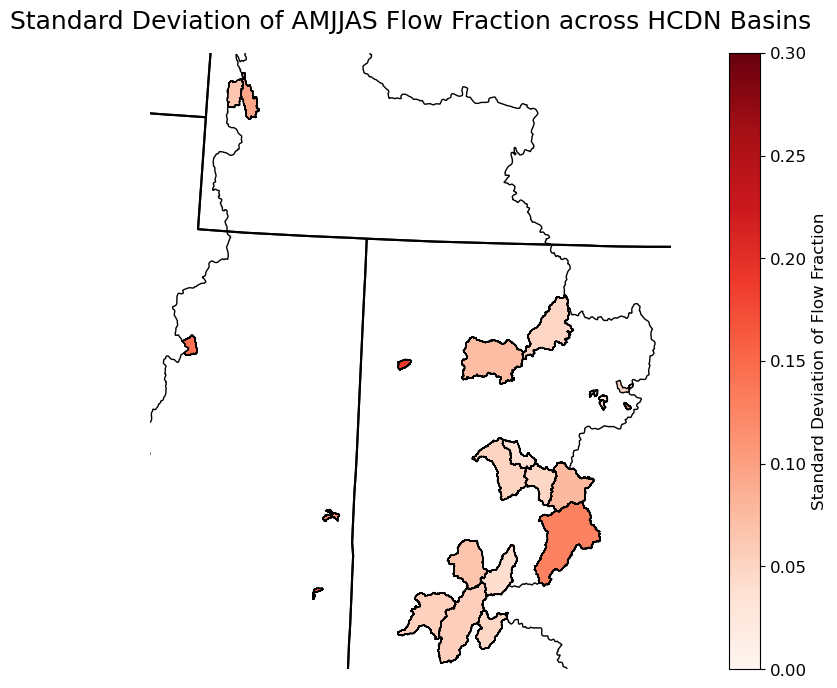

In [270]:
# open ucrb boundary
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(epsg_co)

# open river tracts
river_traces = gpd.read_file('../basin_characteristics/Colorado_River_Basin_Rivers.geojson')
river_traces = river_traces.to_crs(epsg_co)
river_traces = river_traces.clip(ucrb_basin_boundary)
# open us_states
us_states = gpd.read_file('../basin_characteristics/gz_2010_us_040_00_20m.json')
western_states = us_states[us_states['NAME'].isin(['Washington','Oregon','California',
                                                    'Utah','Montana','Idaho','Arizona',
                                                    'New Mexico','Colorado','Nevade','Wyoming'])].to_crs(epsg_co)                                                

fig, ax = plt.subplots(figsize=(15,8))
basin_plot_df = basin_station_sntl_gdf_filtered.copy()
basin_plot_df = basin_plot_df.set_geometry('geom')
# ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
basin_plot_df['AMJJAS_mean'] = AMJJAS_flow_fraction_filtered.groupby('site_no').std()['00060_Mean'].values
# # To create full extent
extent = (basin_plot_df.centroid.x.min()-4e4,
          basin_plot_df.centroid.x.max()+4e4,
          basin_plot_df.centroid.y.min()-4e4,
          basin_plot_df.centroid.y.max()+4e4)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
basin_plot_df.plot(column = 'AMJJAS_mean', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Standard Deviation of Flow Fraction",},
                      missing_kwds ={'color':'dark gray'},
                      cmap='Reds',
                      vmin=0,
                      vmax=0.3,
                      ec='k',
                      ax=ax) #Name the legend


# river_traces.plot(ax=ax, color='blue')
ucrb_basin_boundary.boundary.plot(ax=ax, lw=1,color='k')
western_states.boundary.plot(ax=ax, color='k')

# Titles and Axis Labels
ax.set_title(f'Standard Deviation of AMJJAS Flow Fraction across HCDN Basins', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
# ax.legend()
ax.axis('off')


In [21]:
elevation_idx = station_elevations_df['elev_meters'].sort_values().index

In [42]:
# Mean of AMJJ
AMJJ_flow_fraction_mean = AMJJ_flow_fraction_filtered.groupby('site_no').mean()['00060_Mean'].to_frame()
AMJJ_flow_fraction_mean.index = station_elevations_df.index
AMJJ_flow_fraction_mean_sorted = AMJJ_flow_fraction_mean.loc[elevation_idx]
# Std of AMJJ
AMJJ_flow_fraction_std = AMJJ_flow_fraction_filtered.groupby('site_no').std()['00060_Mean'].to_frame()
AMJJ_flow_fraction_std.index = station_elevations_df.index
AMJJ_flow_fraction_std_sorted = AMJJ_flow_fraction_std.loc[elevation_idx]

# Mean of AMJJAS
AMJJAS_flow_fraction_mean = AMJJAS_flow_fraction_filtered.groupby('site_no').mean()['00060_Mean'].to_frame()
AMJJAS_flow_fraction_mean.index = station_elevations_df.index
AMJJAS_flow_fraction_mean_sorted = AMJJAS_flow_fraction_mean.loc[elevation_idx]
# Std of AMJJAS
AMJJAS_flow_fraction_std = AMJJAS_flow_fraction_filtered.groupby('site_no').std()['00060_Mean'].to_frame()
AMJJAS_flow_fraction_std.index = station_elevations_df.index
AMJJAS_flow_fraction_std_sorted = AMJJAS_flow_fraction_std.loc[elevation_idx]

### Plot of Flow Fraction Mean and Std with elevation

Text(0.5, 1.0, 'Std AMJJAS Flow Fraction')

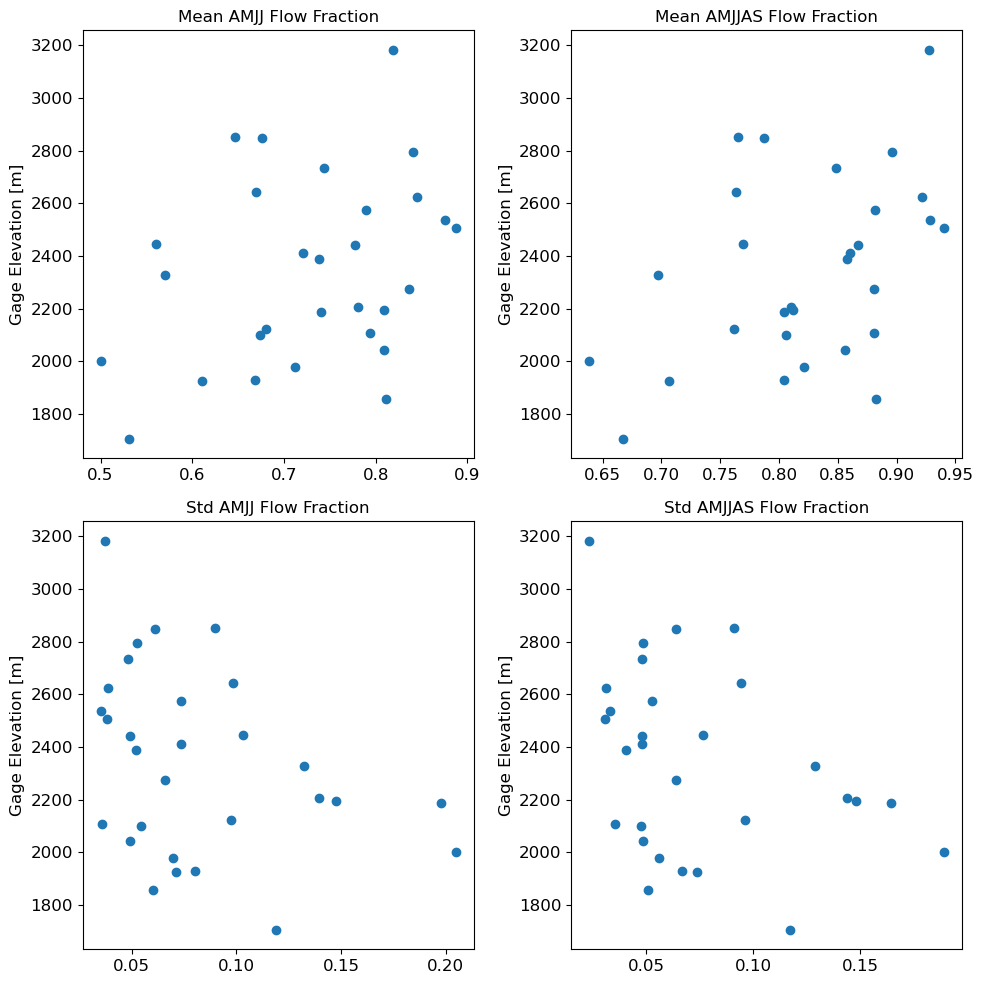

In [48]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), tight_layout=True)
axes=axes.ravel()
axes[0].scatter(AMJJ_flow_fraction_mean_sorted,station_elevations_df['elev_meters'].sort_values().astype(float))
axes[1].scatter(AMJJAS_flow_fraction_mean_sorted,station_elevations_df['elev_meters'].sort_values().astype(float))
axes[2].scatter(AMJJ_flow_fraction_std_sorted,station_elevations_df['elev_meters'].sort_values().astype(float))
axes[3].scatter(AMJJAS_flow_fraction_std_sorted,station_elevations_df['elev_meters'].sort_values().astype(float))

for ax in axes:
    ax.set_ylabel('Gage Elevation [m]')
axes[0].set_title('Mean AMJJ Flow Fraction')
axes[1].set_title('Mean AMJJAS Flow Fraction')
axes[2].set_title('Std AMJJ Flow Fraction')
axes[3].set_title('Std AMJJAS Flow Fraction')

Higher elevation locations generally have a lower standard deviation of flow fraction and a higher mean flow fraction. Values look similar across the different basins

### Here is the same plot with basin area and mean AMJJ

Text(0.5, 1.0, 'Std AMJJAS Flow Fraction')

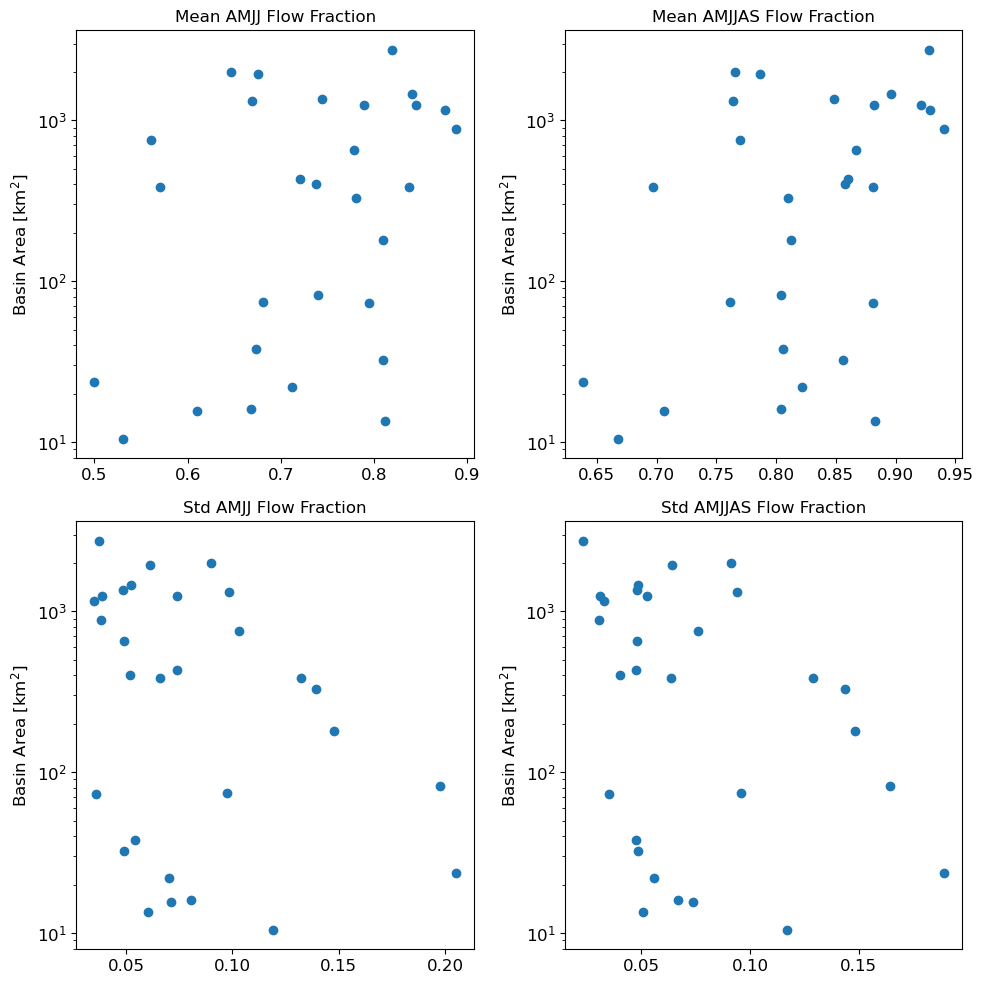

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), tight_layout=True)
axes=axes.ravel()
axes[0].scatter(AMJJ_flow_fraction_mean_sorted,station_elevations_df['basin_area'].sort_values()/1e6)
axes[1].scatter(AMJJAS_flow_fraction_mean_sorted,station_elevations_df['basin_area'].sort_values()/1e6)
axes[2].scatter(AMJJ_flow_fraction_std_sorted,station_elevations_df['basin_area'].sort_values()/1e6)
axes[3].scatter(AMJJAS_flow_fraction_std_sorted,station_elevations_df['basin_area'].sort_values()/1e6)

for ax in axes:
    ax.set_ylabel('Basin Area [km$^2$]')
    ax.set_yscale('log')
axes[0].set_title('Mean AMJJ Flow Fraction')
axes[1].set_title('Mean AMJJAS Flow Fraction')
axes[2].set_title('Std AMJJ Flow Fraction')
axes[3].set_title('Std AMJJAS Flow Fraction')

Larger basins generally have higher streamflow fraction. There is a disconnect between small and large basins though right around 100 km2 in flow standard deviation. Very small basins have higher variability, that increases until the basin is around 100km2, then it reduces again. Mean flow fraction increases generally with larger basins. Perhaps because smaller storms have less of an impact on flow in larger basins?

### Now we will pull in all SNOTEL data that we were looking at earlier:

In [62]:
# First lets print the names of all the snotel's that we want to pull in.
print(f'Number of SNTL site: {len(snotel_list)}')
s = ''
for site in snotel_list:
    s += (site +', ')
print(s)

Number of SNTL site: 56
680:CO:SNTL, 1141:CO:SNTL, 542:CO:SNTL, 380:CO:SNTL, 415:CO:SNTL, 970:CO:SNTL, 1014:CO:SNTL, 842:CO:SNTL, 737:CO:SNTL, 669:CO:SNTL, 618:CO:SNTL, 1252:CO:SNTL, 467:CO:SNTL, 383:UT:SNTL, 1153:UT:SNTL, 1304:UT:SNTL, 572:UT:SNTL, 1215:UT:SNTL, 720:UT:SNTL, 368:UT:SNTL, 513:UT:SNTL, 509:WY:SNTL, 554:WY:SNTL, 544:WY:SNTL, 864:UT:SNTL, 701:CO:SNTL, 1188:CO:SNTL, 538:CO:SNTL, 762:CO:SNTL, 675:CO:SNTL, 629:CO:SNTL, 713:CO:SNTL, 904:CO:SNTL, 1060:CO:SNTL, 739:CO:SNTL, 465:CO:SNTL, 1185:CO:SNTL, 586:CO:SNTL, 589:CO:SNTL, 1061:CO:SNTL, 607:CO:SNTL, 426:CO:SNTL, 913:CO:SNTL, 709:CO:SNTL, 457:CO:SNTL, 940:CO:SNTL, 345:CO:SNTL, 378:CO:SNTL, 827:CO:SNTL, 717:CO:SNTL, 797:CO:SNTL, 843:CO:SNTL, 1160:CO:SNTL, 632:CO:SNTL, 387:CO:SNTL, 780:CO:SNTL, 


### Pull in the SNOTEL data

In [ ]:
sntl_ds = xr.open_dataset('../data/snowdata/')

#### Reproject to 13N UTM Zone

In [146]:
ucrb_hcdn_stations_rpj = ucrb_hcdn_stations[ucrb_hcdn_stations['STAID'].isin(norm_hcdn_mean_ds['site_no'])].to_crs(epsg='32613')

### Import HCDN Basins and reproject to 13N UTM Zone

In [147]:
ucrb_hcdn_basins_rpj = ucrb_hcdn_basins_filtered.to_crs(epsg='32613')
ucrb_hcdn_basins_rpj_centroids = ucrb_hcdn_basins_rpj.geometry.centroid

ucrb_huc4 = gpd.read_file('./ucrb_hcdn_huc4.json')
ucrb_huc4_rpj = ucrb_huc4.to_crs(epsg='32613')

### Pull in all SNTL metadata and MesoNet metadata

In [148]:
# Get SNTL data
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl = gdf_sntl.to_crs(epsg='32613')

In [149]:
nearest_sntl = {}

for i,basin in enumerate(ucrb_hcdn_basins_rpj_centroids):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins_rpj.iloc[i]['STAID']] = [site[0] for site in idx_sntl]

In [150]:
hcdn_df = ucrb_hcdn_basins_filtered[['STAID','STANAME','AREA']].set_index('STAID')
hcdn_df['SNTL_close'] = pd.DataFrame(nearest_sntl).T[0]
hcdn_df['SNTL_second'] = pd.DataFrame(nearest_sntl).T[1]

In [18]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
%matplotlib inline

In [19]:
lees_ferry = gpd.GeoSeries(gpd.points_from_xy(x=[-111.5878722],y=[36.8643333]),crs=4326)


In [21]:
# Import hillshade

ucrb_basin_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(ucrb_hcdn_basins_rpj.crs)

ucrb_hillshade = rioxr.open_rasterio('./ucrb_5states_hillshade_150m.tif').squeeze()
ucrb_hillshade = ucrb_hillshade.rio.reproject("EPSG:32613")
ucrb_hillshade = ucrb_hillshade.rio.clip(ucrb_basin_boundary.geometry)

upscale_factor = 4
new_width = ucrb_hillshade.rio.width / upscale_factor
new_height = ucrb_hillshade.rio.height / upscale_factor

ucrb_hillshade_upsampled = ucrb_hillshade.rio.reproject(
    ucrb_hillshade.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
)

In [53]:
ucrb_hillshade_upsampled.rio.to_raster("./basin_characteristics/ucrb_hillshade_upsample.tif")

<Axes: xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

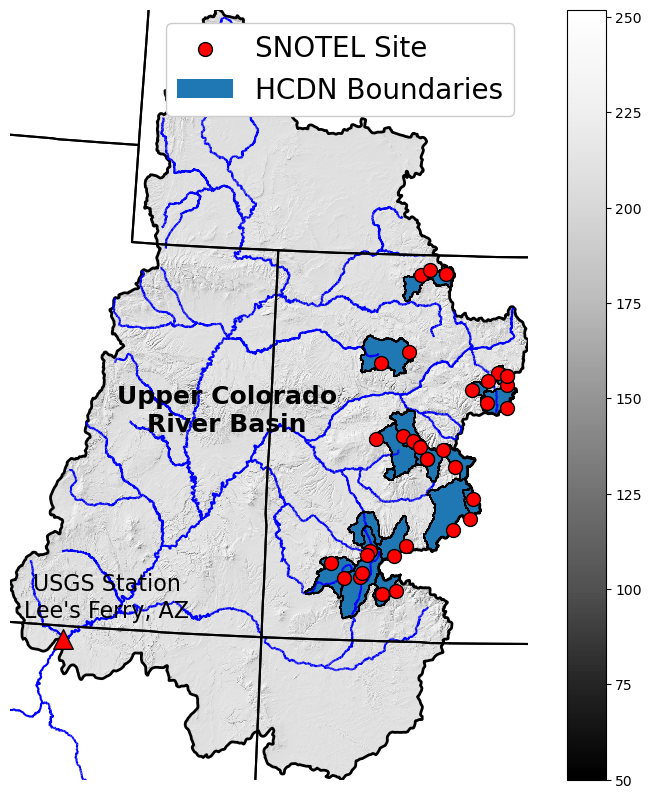

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

# UCRB basin boundary
ucrb_basin_boundary.geometry.plot(ax=ax, color='grey', alpha=0.25, lw=2) 
ucrb_basin_boundary.boundary.plot(ax=ax, color='k', lw=2) 

# Hillshade and river traces
ucrb_hillshade_upsampled.where(ucrb_hillshade_upsampled<255).plot(cmap='Greys_r', ax=ax,vmin=50)
river_traces.plot(ax=ax, color='blue')

# HCDN basins 
ucrb_hcdn_basins_rpj.geometry.plot(ec='k',color='#1f77b4', alpha=1, linewidth=1, ax=ax)
ucrb_hcdn_basins_rpj.boundary.plot(color='k', alpha=1, linewidth=1,ax=ax)

# Lee's Ferry and text
lees_ferry.to_crs(ucrb_hcdn_basins_rpj.crs).plot(ax=ax,markersize=200, marker='^',color='red', ec='k',zorder=10)
ax.text(x=lees_ferry.to_crs(ucrb_hcdn_basins_rpj.crs).geometry.x + 5e4,
        y=lees_ferry.to_crs(ucrb_hcdn_basins_rpj.crs).geometry.y + 0.25e5,
        s="USGS Station\nLee's Ferry, AZ", ha='center', size=16)
ax.bar([],[],color='lightblue',ec='k', label='HCDN Boundaries')
ax.text(x=100000,y=ucrb_basin_boundary.centroid.y,s='Upper Colorado\nRiver Basin', ha='center', size=18, weight='bold')
# ucrb_huc4_rpj.union.boundary.plot(ax=ax)
#Add in hospitals as points
gdf_sntl[gdf_sntl['site_id'].isin([val[0] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', markersize=100, label='SNOTEL Site', ax=ax,zorder=10)
gdf_sntl[gdf_sntl['site_id'].isin([val[1] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', markersize=100, ax=ax,zorder=10)
ax.axis('off')
ax.legend(fontsize=20, framealpha=1)
ax.set_title('')
ax.set_xlim(ucrb_basin_boundary.total_bounds[0],ucrb_basin_boundary.total_bounds[2])
ax.set_ylim(ucrb_basin_boundary.total_bounds[1],ucrb_basin_boundary.total_bounds[3])
#Now adding in the basemap imagery
# cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Stamen.Terrain)
western_states.boundary.plot(ax=ax, color='k')

### Plots for Elevation and Basin Size

Text(0, 0.5, 'Number of Basins')

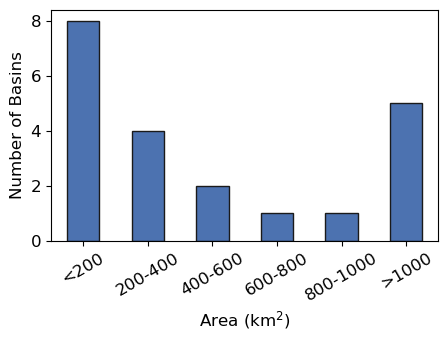

In [336]:
characteristics_df  = pd.read_csv('./hcdn_basin_info.csv', sep='\t')

out = pd.cut(np.array(list(characteristics_df['Drainage Area (km2)'].values)), bins=[0,200, 400,600, 800, 1000, 3000], include_lowest=True)
ax = out.value_counts().plot.bar(rot=0, color="b", figsize=(5,3), label='', ec='k',)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['<200', '200-400', '400-600', '600-800', '800-1000', '>1000'], rotation=30)

plt.ylabel("pct")
plt.xlabel('Area (km$^2$)')
plt.ylabel('Number of Basins')
# plt.legend()

Text(0.5, 0, 'Number of Basins')

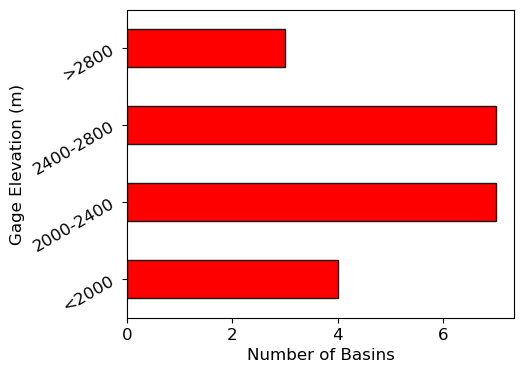

In [340]:
out = pd.cut(np.array(list(characteristics_df['Elevation (m)'].values)), bins=[0,2000, 2400 ,2800, 3800], include_lowest=True)
ax = out.value_counts().plot.barh(rot=0, figsize=(5,4), label='', color='red', ec='k')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['<2000', '2000-2400', '2400-2800','>2800'], rotation=30)

plt.ylabel('Gage Elevation (m)')
plt.xlabel('Number of Basins')

In [59]:
naturalized_flow_full = pd.read_csv('./LF_NATURALIZED_FLOW.csv', index_col=0, header=None, names=['WY_naturalized_flow'])
naturalized_flow = naturalized_flow_full.loc[1980:2022]


Naturalized Flow at Lee's Ferry
Historical PRISM
NARR
SNOTEL
PRISM
WRF-1km
GRACE


Text(0.5, 1.0, "USBR Naturalized Streamflow at Lee's Ferry, AZ")

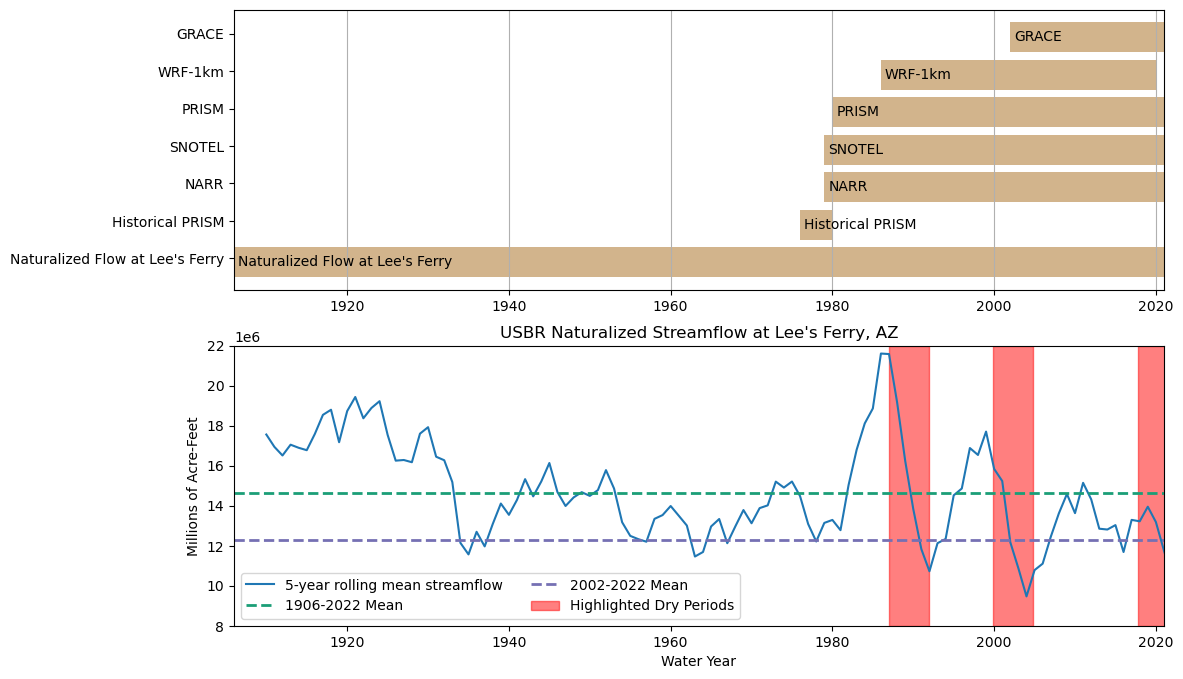

In [282]:
source = pd.DataFrame([
    {"data": "Naturalized Flow at Lee's Ferry","start": '1906-01-01', "end": '2021-10-01'},
    {"data": "Historical PRISM","start": '1976-09-30', "end": '1980-09-30'}, 
    {"data": "NARR","start": '1979-01-01', "end": '2021-10-01'}, 
    {"data": "SNOTEL","start": '1979-09-30', "end": '2021-10-01'},
    {"data": "PRISM","start": '1980-09-30', "end": '2021-10-01'},
    {"data": "WRF-1km","start": '1986-10-01', "end": '2020-10-01'}, 
    {"data": "GRACE", "start": '2002-05-01', "end": '2021-10-01'},
])
source['start'] = pd.to_datetime(source['start'])
source['end'] = pd.to_datetime(source['end'])
source['diff'] = source['end'] - source['start']
 
# Declaring a figure "gnt"
fig, axs = plt.subplots(nrows=2, figsize=(12,8))
gnt=axs[0] 
# Need to fix hidden tick labels
# https://stackoverflow.com/questions/43673659/matplotlib-not-showing-first-label-on-x-axis-for-the-bar-plot
 
y_tick_labels = source.data.values
y_pos = np.arange(len(y_tick_labels))
 
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)
 
 
# https://sparkbyexamples.com/python/iterate-over-rows-in-pandas-dataframe/
# https://www.tutorialspoint.com/plotting-dates-on-the-x-axis-with-python-s-matplotlib
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
# https://www.geeksforgeeks.org/how-to-annotate-matplotlib-scatter-plots
for index, row in source.sort_values(by='start', ascending=True).iterrows():
    print(row.data)
    start_year = int(row.start.strftime("%Y"))
    duration = row['diff'].days/365
    gnt.broken_barh([(start_year, duration)], 
                    (index-0.5,0.8), 
                    facecolors =('tan'),
                   label=row.data)
    gnt.text(start_year+0.5, index-0.2, row.data)
gnt.grid(axis='x')
gnt.set_xlim(1906,2021)

ax = axs[1]
colors = ['#1b9e77',
          '#d95f02',
          '#7570b3']
ax.plot(naturalized_flow_full.rolling(5).mean().index,
        naturalized_flow_full.rolling(5).mean(), 
        label="5-year rolling mean streamflow")
ax.axhline(naturalized_flow_full.mean().values[0], color=colors[0], ls='--',lw=2, label="1906-2022 Mean")
# ax.axhline(naturalized_flow.mean().values[0], color=colors[1], ls='--',lw=2, label="1980-2022 Mean")
ax.axhline(naturalized_flow_full.loc[2002:2022].mean().values[0], color=colors[2], ls='--',lw=2, label="2002-2022 Mean")
ax.axvspan(1987,1992,alpha=0.5, color='red', label='Highlighted Dry Periods')
ax.axvspan(1999.8,2004.75,alpha=0.5, color='red')
ax.axvspan(2017.75,2021.75,alpha=0.5, color='red')
# ax.axvspan(1980,2021,alpha=0.25, color='red', label='SWE-Q Residual Time Series')
# ax.axvspan(2002,2021,alpha=0.5, facecolor="none", hatch="XX", edgecolor="b", label='GRACE Availability',linewidth=0.0)
ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
ax.legend(loc='lower left', ncols=2)
ax.set_ylabel('Millions of Acre-Feet')
ax.set_xlabel('Water Year')
ax.set_xlim(1906,2021)
ax.set_ylim(8e6,22e6)
ax.set_title("USBR Naturalized Streamflow at Lee's Ferry, AZ")

In [55]:
northern_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y > 4.35e6)]['STAID']
central_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y < 4.35e6) & (ucrb_hcdn_basins_rpj_centroids.y > 4.25e6)]['STAID']
southern_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y < 4.25e6)]['STAID']


### Request SNTL data

In [151]:
closest_sntl_swe_ds = xr.open_dataset('./hcdn_closest_sntl_20220930_corr.nc')
closest_sntl_april_1_swe = closest_sntl_swe_ds.where((closest_sntl_swe_ds.Date.dt.month==4)&(closest_sntl_swe_ds.Date.dt.day==1))['WTEQ'].to_dataframe().dropna().to_xarray()
norm_closest_sntl_april_1_swe = (closest_sntl_april_1_swe-closest_sntl_april_1_swe.mean(dim='Date'))/closest_sntl_april_1_swe.std(dim='Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sortby('Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sel(Date=slice('1981-4-1','2021-4-2'))
norm_closest_sntl_april_1_swe['Date'] = norm_closest_sntl_april_1_swe['Date'].dt.year

if 'datetime' in norm_hcdn_mean_ds.dims:
    norm_hcdn_mean_ds['datetime'] = norm_hcdn_mean_ds['datetime'].dt.year-1

In [152]:
second_sntl_swe_ds = xr.open_dataset('./hcdn_second_closest_sntl_20210930.nc')
second_sntl_april_1_swe = second_sntl_swe_ds.where((second_sntl_swe_ds.Date.dt.month==4)&(second_sntl_swe_ds.Date.dt.day==1))['WTEQ'].to_dataframe().dropna().to_xarray()
norm_second_sntl_april_1_swe = (second_sntl_april_1_swe-second_sntl_april_1_swe.mean(dim='Date'))/second_sntl_april_1_swe.std(dim='Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sortby('Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sel(Date=slice('1987-4-1','2021-4-2'))
norm_second_sntl_april_1_swe['Date'] = norm_second_sntl_april_1_swe['Date'].dt.year

In [153]:
def linreg_output(swe, q):
    slope, intercept, rvalue, pvalue,stderr  = stats.linregress(swe, q)

    alpha = 0.05
    c = (1 - alpha)

    # Create regression line and residuals
    X = swe
    y_predicted = intercept + slope*X
    residual = (q-y_predicted)

    # Setup 
    n = X.size                                               
    dof = n - 2
    t = stats.t.ppf(c, dof) 

    # sum of squared errors
    sse = np.sum(residual**2)

    # total sum of squares (y)
    sst = np.sum( (q - np.mean(q))**2 )

    # total sum of squares (x)
    sst_x = np.sum( (X - np.mean(X))**2 )

    # correlation coefficient
    r_squared = 1 - sse/sst

    # standard error of regression
    s = np.sqrt(sse/(n-2))

    # an array of x values
    p_x = np.linspace(X.min(),X.max(),100)

    # using our model parameters to predict y values
    p_y = intercept + slope*p_x

    # compute error of prediction for each p_x
    sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
    # set our confidence interval

    p_y_lower = p_y - t * sigma_ep
    p_y_upper = p_y + t * sigma_ep
    return X, intercept, slope, residual, r_squared, p_x, p_y_lower, p_y_upper

### For Plotting a single basin

In [252]:
 # get nearest sntl site
 loc='09112500'
sntl_site_close = nearest_sntl[loc][0]
sntl_site_far = nearest_sntl[loc][1]

# Calculate normalized
if (sntl_site_close not in closest_sntl_april_1_swe.Location):
    print(f'Using Far Location for {loc}')
    sntl_site = sntl_site_far
    normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() *10
elif (len(closest_sntl_april_1_swe.sel(Location=sntl_site_close).to_dataframe().dropna().index) <= 14): 
    print(f'Using Far Location for {loc}')
    sntl_site = sntl_site_far
    normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() *10
else:
    sntl_site = sntl_site_close
    normalized_april_1_swe = closest_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() *10

q_apr1_sep30 = (hcdn_q_spring_summer_sum_ds).sel(year=slice(1980,2021),site_no=loc)['00060_Mean'].to_dataframe().dropna()
q_apr1_sep30['00060_Mean'] = q_apr1_sep30['00060_Mean'] *1000/748.5e6 
normalized_q_apr1_sep30 = norm_hcdn_mean_ds.sel(site_no=loc)['00060_Mean'].to_dataframe().dropna()
normalized_april_1_swe.index = normalized_april_1_swe.index.year
tmp_df = q_apr1_sep30.merge(normalized_april_1_swe, left_index=True, right_index=True)
# Filtering to find where
# tmp_df = tmp_df.where(np.abs(tmp_df['WTEQ'] - tmp_df['00060_Mean']) <2).dropna()

# Run linreg function to get output
X, intercept, slope, residual, r_squared, p_x, p_y_lower, p_y_upper = linreg_output(tmp_df['WTEQ'].values, tmp_df['00060_Mean'].values)
residual = pd.Series(residual, index=tmp_df.index)

Text(0.5, 1.0, '(b)')

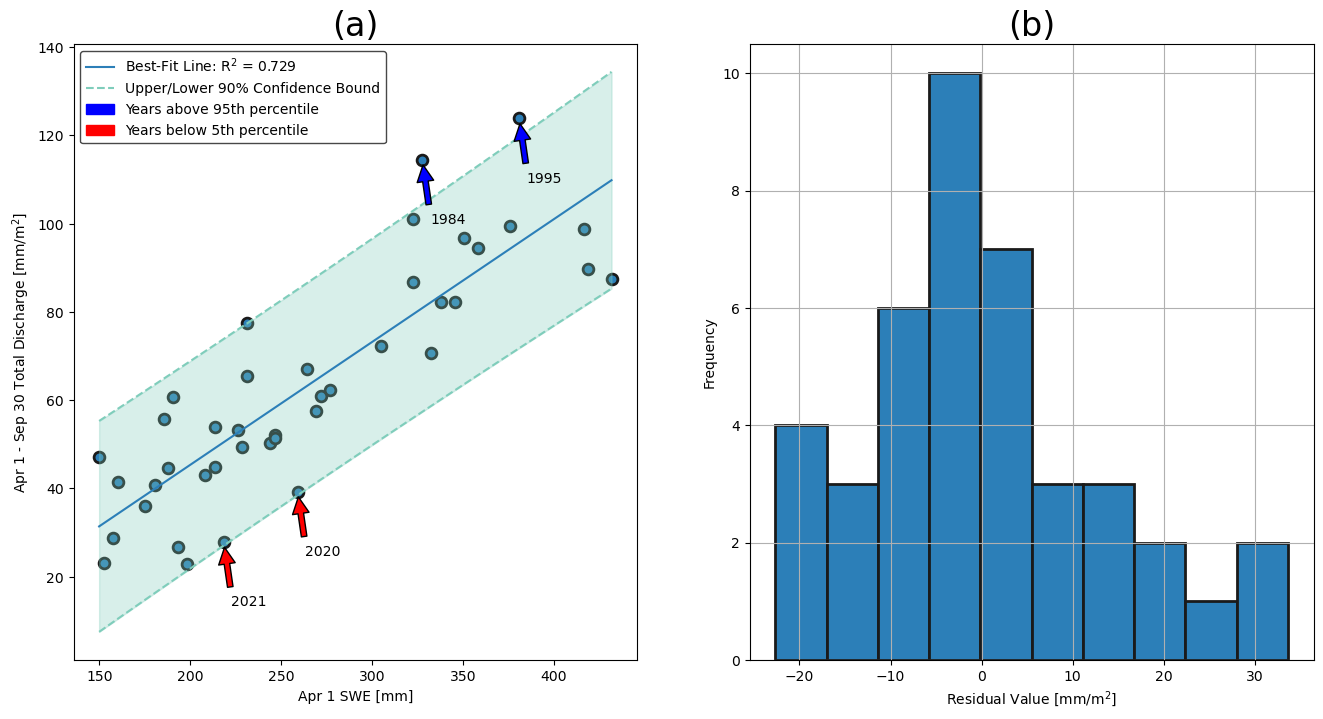

In [258]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))
colors = ['#2c7fb8','#7fcdbb']
idx_95th_percentile = (residual[residual < np.percentile(residual,5)].index).values
idx_5th_percentile = residual[residual > np.percentile(residual,95)].index.values

axs[0].scatter(tmp_df['WTEQ'], tmp_df['00060_Mean'], color=colors[0], edgecolor='k', s=60, lw=2)
axs[0].plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label=f'Best-Fit Line: R$^2$ = {round(r_squared,3)}')
# axs[0].plot([X.min(),X.max()], [X.min(),X.max()], color='grey',ls='--', label=f'1:1 Line')
axs[0].plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
axs[0].plot(p_x, p_y_upper, color=colors[1], ls='--', )
axs[0].fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)

for i,idx in enumerate(idx_5th_percentile):
    if idx in [2012,2017,2018]:
        axs[0].annotate(str(idx), 
                    (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]),
                    (normalized_april_1_swe['WTEQ'].loc[idx]+0.2, q_apr1_sep30['00060_Mean'].loc[idx]-0.4),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)
    elif idx in [2003]:
        axs[0].annotate(str(idx), 
                    (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]),
                    (normalized_april_1_swe['WTEQ'].loc[idx]+0.4, q_apr1_sep30['00060_Mean'].loc[idx]+0.2),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)
    else:
        axs[0].annotate(str(idx), 
                        (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]),
                        (normalized_april_1_swe['WTEQ'].loc[idx]+14, q_apr1_sep30['00060_Mean'].loc[idx]-12),
                        arrowprops=dict(facecolor='blue', shrink=0.1),
                        horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_95th_percentile):
    if idx == 2001:
        axs[0].annotate(str(idx), 
                (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]),
                (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
    else:
        axs[0].annotate(str(idx), 
                (normalized_april_1_swe['WTEQ'].loc[idx], q_apr1_sep30['00060_Mean'].loc[idx]),
                (normalized_april_1_swe['WTEQ'].loc[idx]+14, q_apr1_sep30['00060_Mean'].loc[idx]-12),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

axs[0].arrow([],[],[],[], color='blue', label='Years above 95th percentile',width=0.1)
axs[0].arrow([],[],[],[], color='red', label='Years below 5th percentile',width=0.1)
axs[0].set_xlabel('Apr 1 SWE [mm]')
axs[0].set_ylabel('Apr 1 - Sep 30 Total Discharge [mm/m$^2$]')
axs[0].set_title('(a)', size=24)
axs[0].legend(edgecolor='k', facecolor='white')

axs[1].hist(residual.values,bins=10, color=colors[0], edgecolor='k', lw=2)
# axs[1].axvline(0, lw=3, color='r', label='Residual = 0')
axs[1].grid()
axs[1].set_xlabel('Residual Value [mm/m$^2$]')
axs[1].set_ylabel('Frequency')
axs[1].set_title('(b)', size=24)
# axs[1].legend(edgecolor='k', facecolor='white')
# axs[1].set_xlim(-1,1)

KeyError: '09239500'

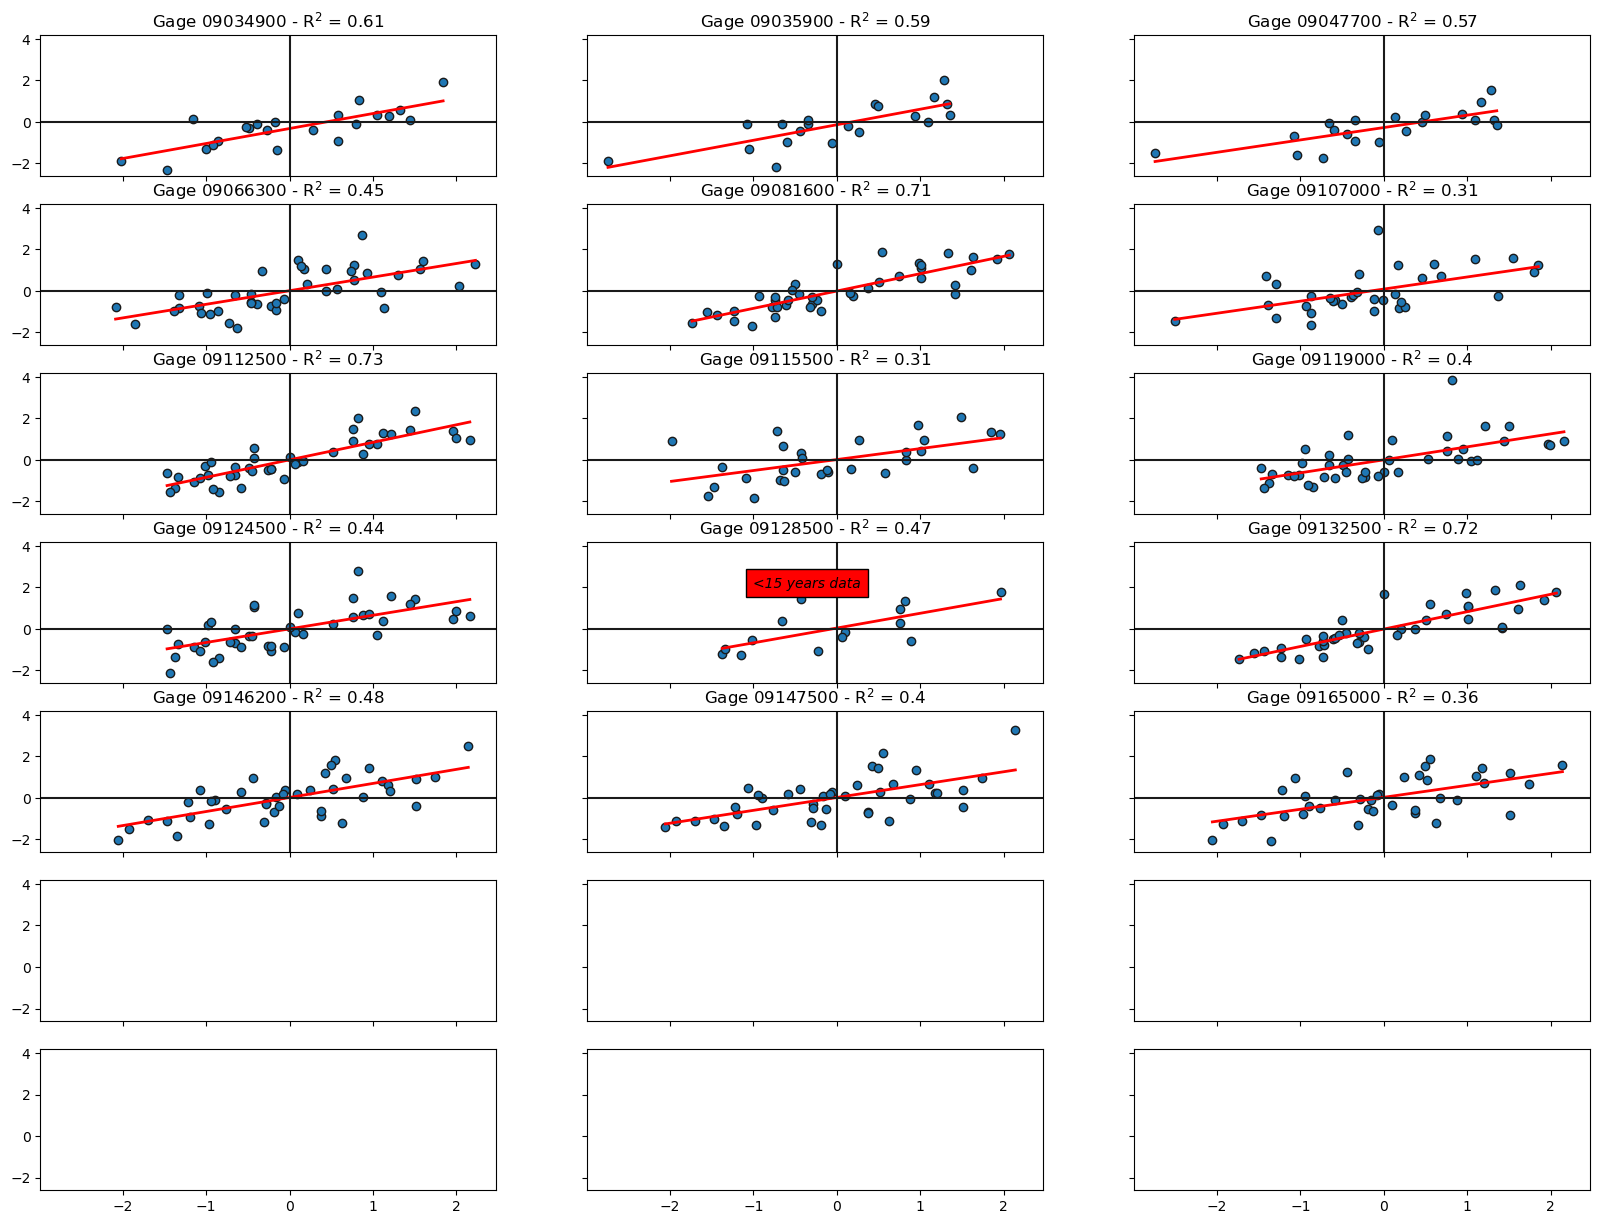

In [156]:
colors = ['#2c7fb8','#7fcdbb']
residuals = {}
fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(20,15), sharex=True, sharey=True, facecolor='white')
axs=axs.ravel()

for i,loc in enumerate(list(column_dict.keys())):
    # Set axis for plotting
    ax=axs[i]
    # get nearest sntl site
    sntl_site_close = nearest_sntl[loc][0]
    sntl_site_far = nearest_sntl[loc][1]

    # Calculate normalized
    if (sntl_site_close not in norm_closest_sntl_april_1_swe.Location):
        print(f'Using Far Location for {loc}')
        sntl_site = sntl_site_far
        normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    elif (len(norm_closest_sntl_april_1_swe.sel(Location=sntl_site_close).to_dataframe().dropna().index) <= 14): 
        print(f'Using Far Location for {loc}')
        sntl_site = sntl_site_far
        normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    else:
        sntl_site = sntl_site_close
        normalized_april_1_swe = norm_closest_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
       
    normalized_q_apr1_sep30 = norm_hcdn_mean_ds.sel(site_no=loc)['00060_Mean'].to_dataframe().dropna()
    tmp_df = normalized_q_apr1_sep30.merge(normalized_april_1_swe, left_index=True, right_index=True)
    # Filtering to find where
    # tmp_df = tmp_df.where(np.abs(tmp_df['WTEQ'] - tmp_df['00060_Mean']) <2).dropna()

    # Run linreg function to get output
    X, intercept, slope, residual, r_squared, _, _, _ = linreg_output(tmp_df['WTEQ'].values, tmp_df['00060_Mean'].values)
    residuals[loc] = pd.Series(residual, index=tmp_df.index)

    # Plotting up each location
    ax.scatter(tmp_df['WTEQ'], tmp_df['00060_Mean'], ec='k')
    # Plotting each bestfit line
    ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color='red',lw=2, label='Best-Fit Line')
    if len(tmp_df.index) < 15:
        ax.text(-1, 2, '<15 years data', style='italic',
        bbox={'facecolor': 'red', 'alpha': 1, 'pad': 5})
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_title(f'Gage {loc} - R$^2$ = {round(r_squared,2)}')

fig.text(0.5, 0.06, 'Normalized April 1 SWE Anomaly', ha='center', size=18)
fig.text(0.05, 0.5, 'Normalized Apr1 - Sep30 Q', va='center', rotation='vertical', size=18)
fig.suptitle(t="SWE-Q Relationship within selected UCRB HCDN Basins", size=30)

In [68]:
ordered_idx = {}
residual_df = pd.DataFrame(residuals)
residual_df = residual_df.rename(columns=dict(zip(ucrb_hcdn_basins_filtered.STAID,ucrb_hcdn_basins_filtered.STANAME)))
for col in residual_df.columns:
    ordered_idx[col] = residual_df[col].sort_values(na_position='last').index
    ordered_idx[f'{col}_flag'] = residual_df[col].sort_values(na_position='last').isna().reset_index(drop=True)

ordered_idx_df = pd.DataFrame(ordered_idx)

In [69]:
good_col_list = []
for i,col in enumerate(ordered_idx_df.columns):
    if i % 2 != 0:
        if ordered_idx_df[col].sum() <= 5:
            good_col_list.extend([ordered_idx_df.columns[i-1]])

### Signals of Fall Soil Moisture

In [70]:
cbrfc_sm = rioxr.open_rasterio('../../data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(ucrb_hcdn_basins_rpj.crs, resampling=Resampling.cubic)

In [71]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
hcdn_soil_moisture = {}
for row, basin in ucrb_hcdn_basins_rpj.iterrows():
    # clip to basin 
    print(f'Working on {basin.STAID}')
    tmp = gpd.GeoDataFrame(basin).T
    # try:
    basin_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(tmp.geometry)
    basin_cbrfc_sm_rpj_basin_mean = basin_cbrfc_sm_rpj.sel(year=slice(1980,2021)).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
    norm_er_cbrfc_rpj_basin_mean = (basin_cbrfc_sm_rpj_basin_mean-basin_cbrfc_sm_rpj_basin_mean.mean())/basin_cbrfc_sm_rpj_basin_mean.std()
    hcdn_soil_moisture[basin.STANAME] = norm_er_cbrfc_rpj_basin_mean.values
    # except:
    #     print('No Overlapping Data...')
    #     pass

Working on 09034900
Working on 09035900
Working on 09035800
Working on 09047700
Working on 09066300
Working on 09081600
Working on 09107000
Working on 09112500
Working on 09115500
Working on 09119000
Working on 09124500
Working on 09128500
Working on 09132500
Working on 09146200
Working on 09147500
Working on 09165000
Working on 09241000
Working on 09245000
Working on 09304500
Working on 09352900
Working on 09361500


In [72]:
ordered_sm = {}
hcdn_fall_soil_moisture_anomaly = pd.DataFrame(hcdn_soil_moisture).dropna(axis=1).set_index(np.arange(1980,2022,1))
for col in hcdn_fall_soil_moisture_anomaly.columns:
    ordered_sm[col] = hcdn_fall_soil_moisture_anomaly[col].sort_values(na_position='last').index

ordered_sm_df = pd.DataFrame(ordered_sm)

In [73]:
to_exclude = [
    'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
    'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
    'TAYLOR RIVER AT ALMONT, CO.',
    'CURECANTI CREEK NEAR SAPINERO, CO.',
    'MILK CREEK NEAR THORNBURGH, CO.',
    'BLACK GORE CREEK NEAR MINTURN, CO.',
    'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
    'BOOTH CREEK NEAR MINTURN, CO.',
    'ELKHEAD CREEK NEAR ELKHEAD, CO.', 
    'DOLORES RIVER BELOW RICO, CO.'
]
idx_order = [name for name in northern_names] +[name for name in central_names] +[name for name in southern_names] 
sm_cols = [col for col in idx_order if col not in to_exclude]


Text(0.5, 1.0, 'CBRFC Fall Soil Moisture Anomaly')

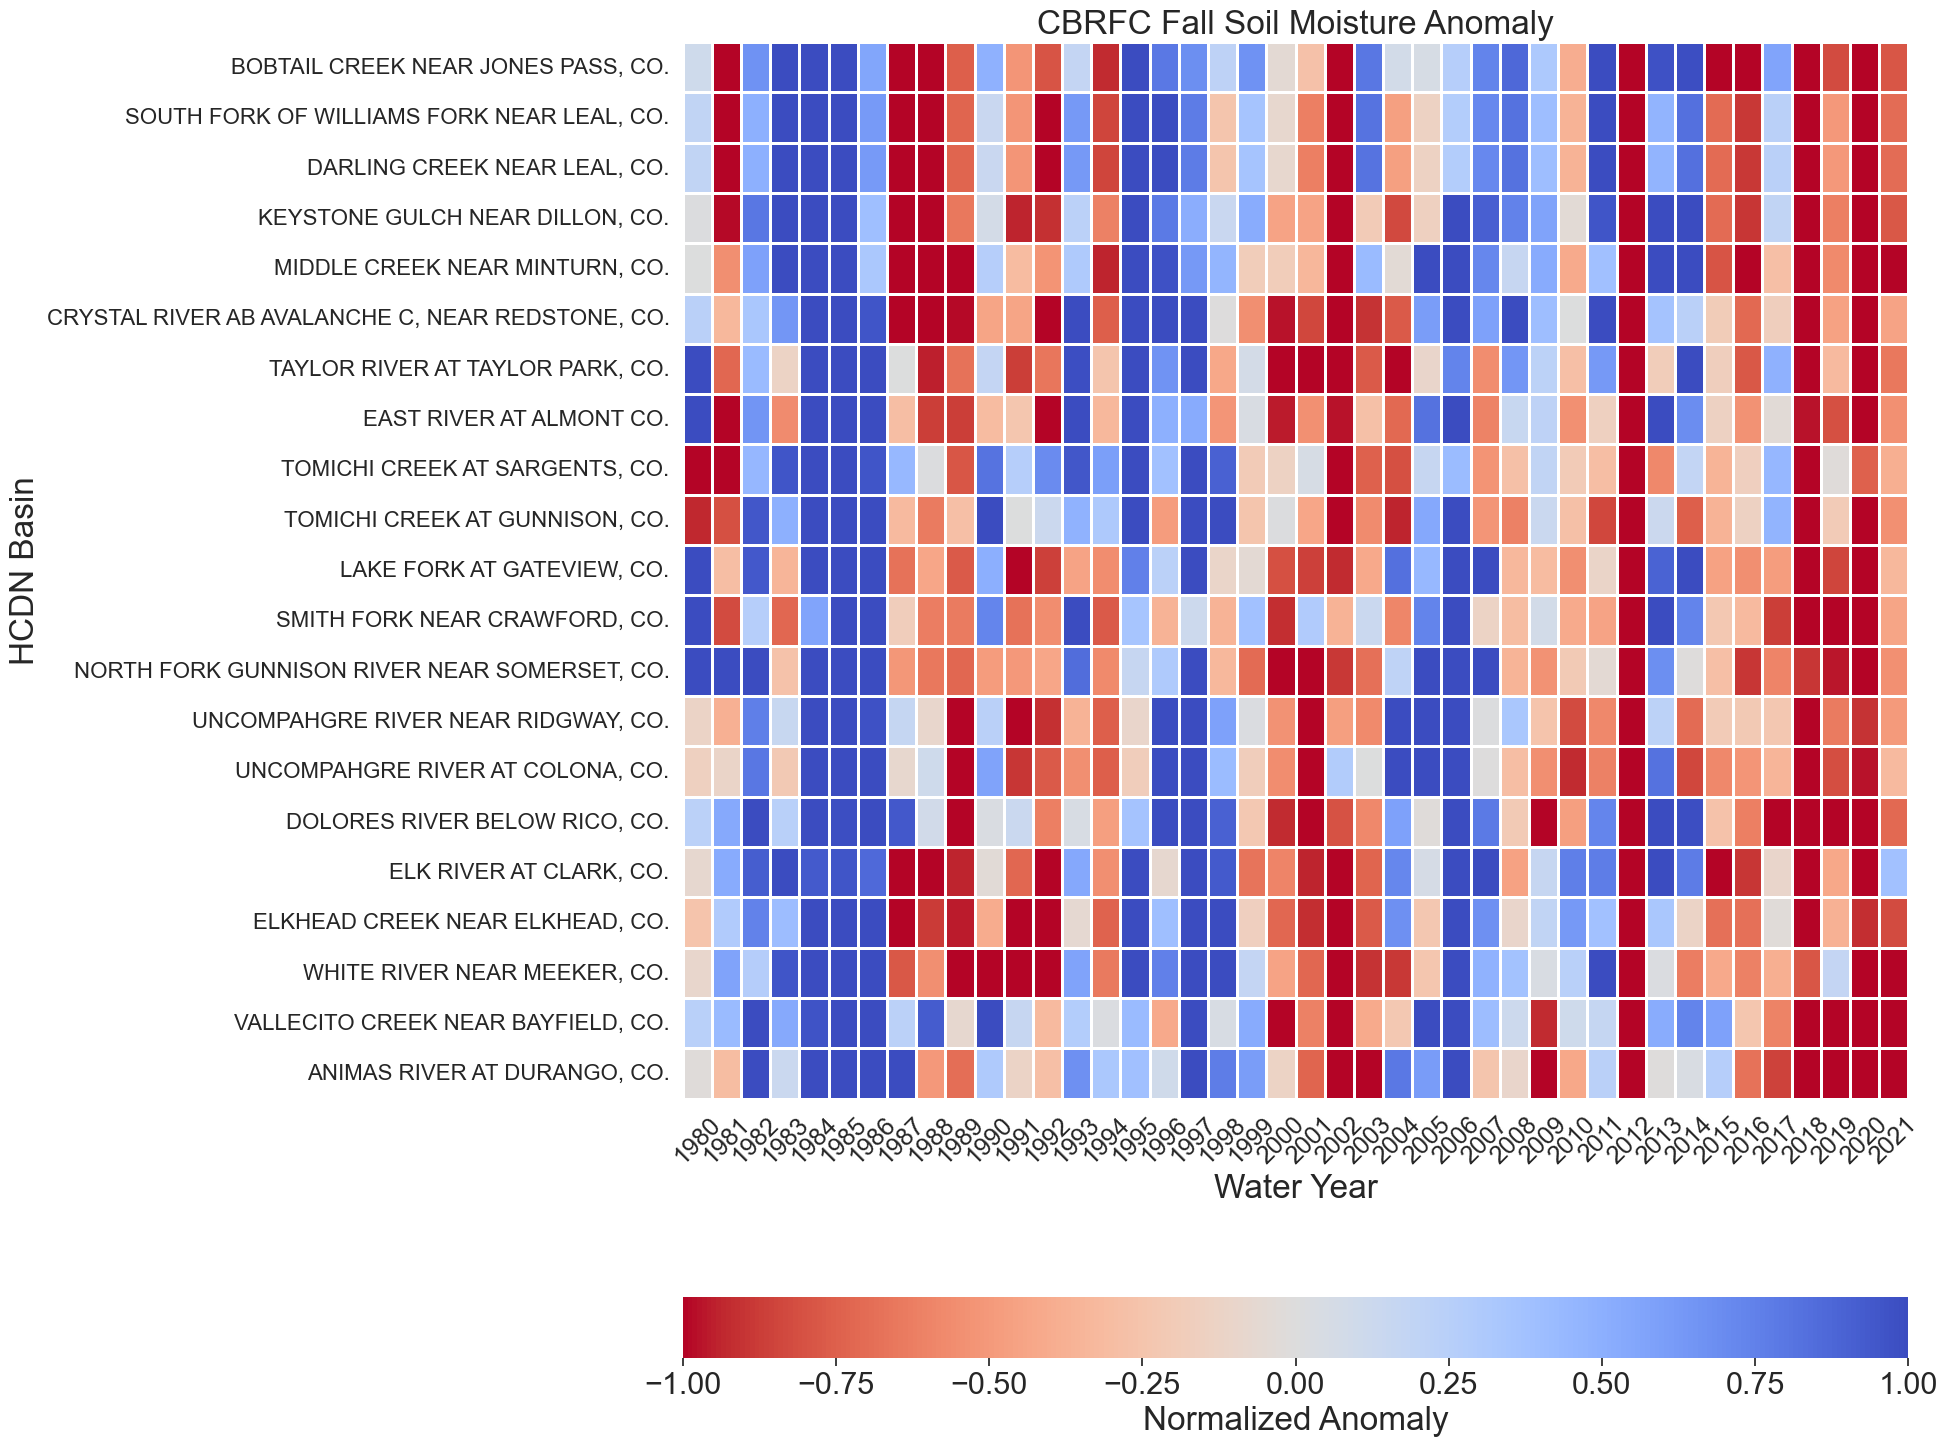

In [74]:
sns.set(font_scale=2)
fig, ax=plt.subplots(nrows=1,figsize=(20,15), facecolor='w',tight_layout=True)
hcdn_sm_transpose = hcdn_fall_soil_moisture_anomaly.T
sns.heatmap(hcdn_sm_transpose, 
            cmap='coolwarm_r', 
            vmin=-1, 
            vmax=1,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.set_yticklabels(hcdn_sm_transpose.index, rotation=0, ha='right', size=16);
ax.set_xticklabels(hcdn_sm_transpose.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('HCDN Basin',size=24)
ax.set_xlabel('Water Year', size=24)
ax.set_title('CBRFC Fall Soil Moisture Anomaly', size=24)


In [75]:
# Override with the data I want to use for this location
# residual_df['TAYLOR RIVER AT TAYLOR PARK, CO.'] = np.array([ np.nan, 0.34557071, -0.14298503,  0.47592956, -0.01998377, -0.39544826,
#                                                             0.24951214,  0.35746921,  1.53799736,  0.35191506, -0.20010432,
#                                                             -0.33510814,  0.79624942,  0.37863125,  0.82413007, -0.35569593,
#                                                             -0.34242697, -0.62262998, -0.2566138 , -0.42504686,  0.14299915,
#                                                             -0.1662122 ,  0.45736588, -0.09986152,  0.14128553, -0.59512815,
#                                                             0.09032721, -0.04507207,  0.98027981, -0.28053247, -0.61903316,
#                                                             -0.77346242,  0.34928536, -0.94963403, -0.85396863])
# residual_df['EAST RIVER AT ALMONT, CO.'] = np.array([-0.23159395, -0.13285317,  0.01517729,  0.35308609,  0.42713705,
#                                                     -0.21398927, -0.40581044,  0.20014016,  0.61270374,  0.1087555 ,
#                                                     -0.13075471, -0.23426521,  0.41909599,  0.38080882,  0.23119003,
#                                                     -0.52792811, -0.45857949, -0.4540319 , -0.5185571 , -0.14891301,
#                                                         0.02161103, -0.41115783,  0.35298337, -0.02981432,  0.58589907,
#                                                     -0.06006049,  0.23025695,  0.76803584,  0.40207064, -0.14659155,
#                                                     -0.18250982, -0.23335044,  0.53690603, -0.56131493, -0.56378185])

Text(0.5, 1.0, 'Normalized SWE-Q Residual')

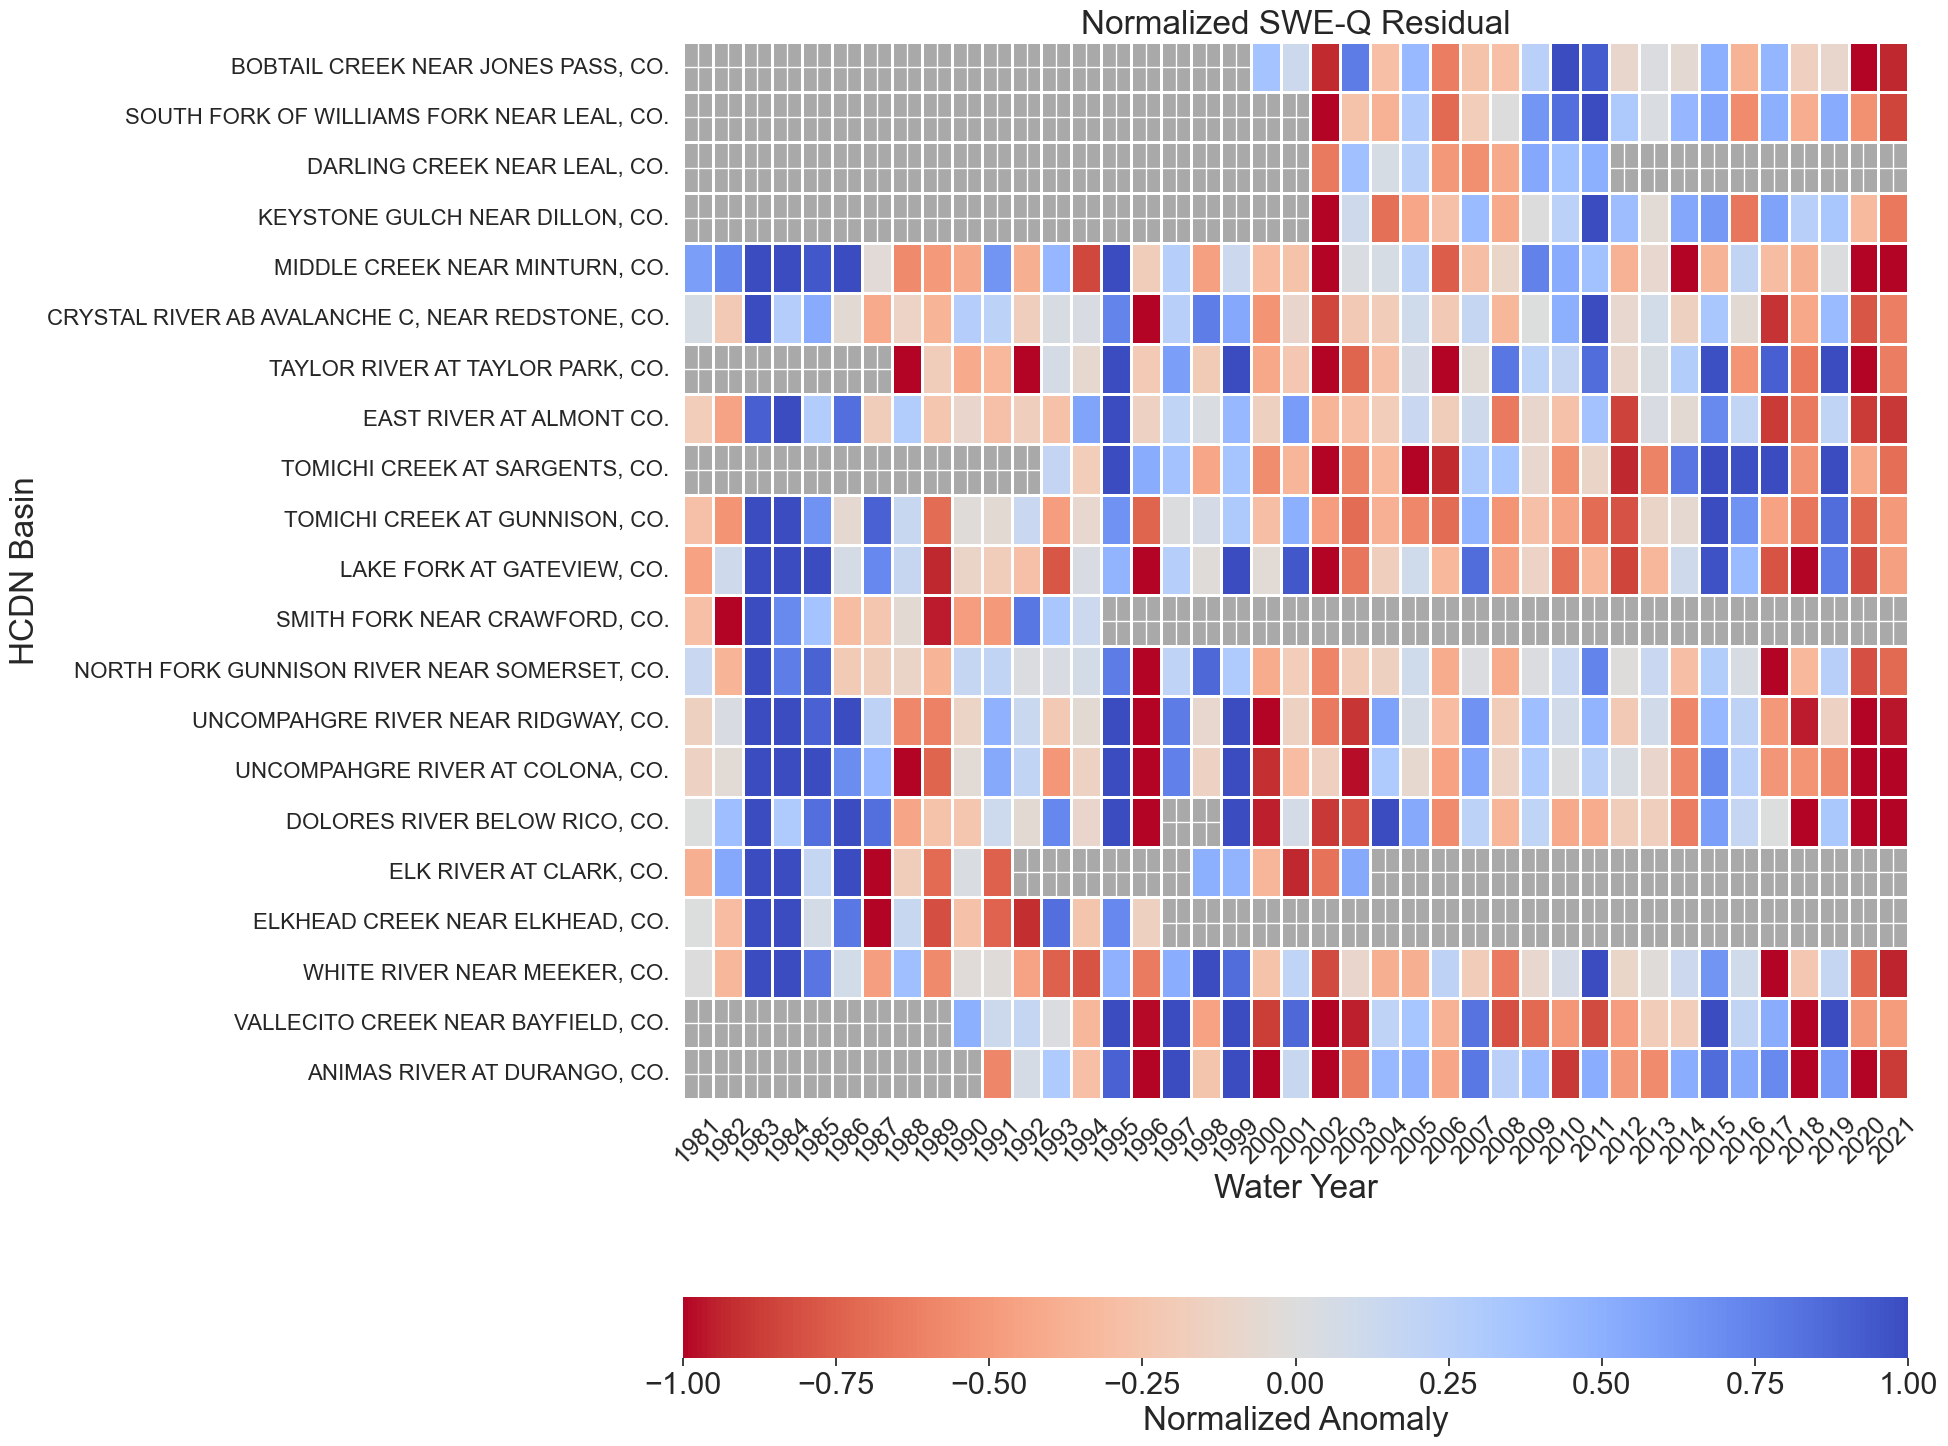

In [76]:
sns.set(font_scale=2, rc={'axes.facecolor':'darkgrey'})
fig, ax=plt.subplots(nrows=1,figsize=(20,15), facecolor='w',tight_layout=True)
hcdn_residual_transpose = residual_df.T
sns.heatmap(hcdn_residual_transpose, 
            cmap='coolwarm_r', 
            vmin=-1, 
            vmax=1,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.set_yticklabels(hcdn_residual_transpose.index, rotation=0, ha='right', size=16);
ax.set_xticklabels(hcdn_residual_transpose.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('HCDN Basin',size=24)
ax.set_xlabel('Water Year', size=24)
ax.set_title('Normalized SWE-Q Residual', size=24)

In [79]:
ucrb_basin_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(ucrb_hcdn_basins_rpj_centroids.crs)
ucrb_basin_boundary.boundary.plot(ax=ax, label='Upper Colorado River Basin', lw=2)

<Axes: title={'center': 'Normalized SWE-Q Residual'}, xlabel='Water Year', ylabel='HCDN Basin'>

<Figure size 640x480 with 0 Axes>

In [260]:
year_to_plot = '2018-2021'
year_to_plot_list = [2018,2020,2021]

(181936.9814590584, 461457.3118677341, 4118161.6868092977, 4556952.5356851285)

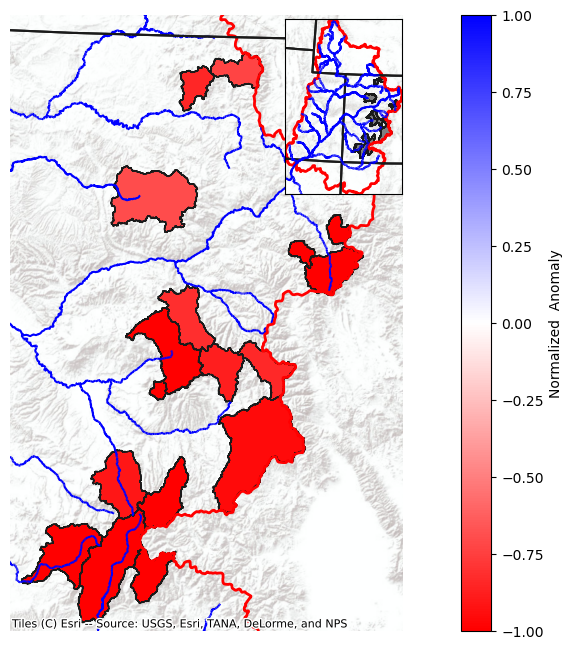

In [134]:
fig, ax = plt.subplots(figsize=(15,8))

# ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
ucrb_hcdn_basins_rpj[year_to_plot] = hcdn_sm_transpose[year_to_plot_list].mean(axis=1).values
# To create full extent
extent = (ucrb_hcdn_basins_rpj_centroids.x.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.x.max()+4e4,
          ucrb_hcdn_basins_rpj_centroids.y.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.y.max()+4e4)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
ucrb_hcdn_basins_rpj.plot(column = year_to_plot, #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Normalized  Anomaly",},
                      missing_kwds ={'color':'dark gray'},
                      cmap='bwr_r',
                      vmin=-1,
                      vmax=1,
                      ec='k',
                      ax=ax) #Name the legend


river_traces.plot(ax=ax, color='blue')
ucrb_basin_boundary.boundary.plot(ax=ax, lw=2,color='red')
western_states.boundary.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain)

# # subregion of the original image 1
x1, y1, x2, y2 = ucrb_basin_boundary.total_bounds
# inset axes....
axins = ax.inset_axes([0.7,0.7,0.3,0.3])
ucrb_hcdn_basins_rpj.geometry.plot(ax=axins,color='grey',ec='k')
ucrb_basin_boundary.boundary.plot(ax=axins, lw=2,color='red')
western_states.boundary.plot(ax=axins, color='k')
river_traces.plot(ax=axins, color='blue')
cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain, attribution='')
# subregion of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins, edgecolor="black")


# Titles and Axis Labels
# ax.set_title(f'HCDN Basin Fall Soil Moisture Anomaly for WY{year_to_plot}\n(Missing values in grey)', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
# ax.legend()
ax.axis('off')


(181936.9814590584, 461457.3118677341, 4118161.6868092977, 4556952.5356851285)

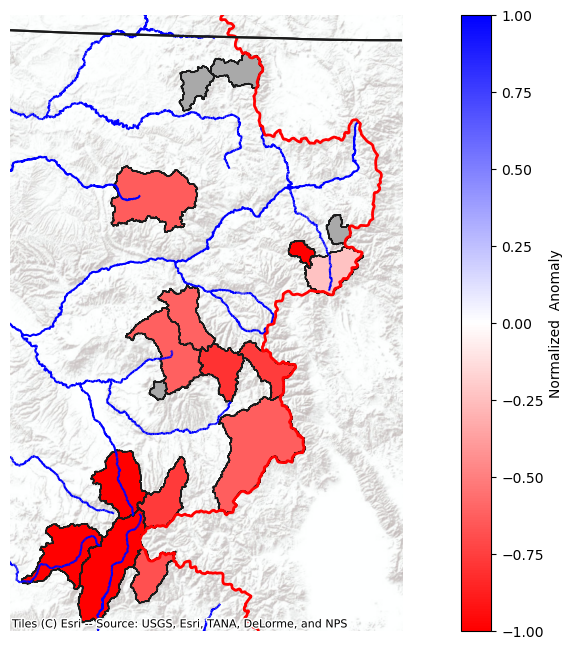

In [265]:
fig, ax = plt.subplots(figsize=(15,8))

# ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
ucrb_hcdn_basins_rpj[year_to_plot] = hcdn_residual_transpose[year_to_plot_list].mean(axis=1).values
# To create full extent
extent = (ucrb_hcdn_basins_rpj_centroids.x.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.x.max()+4e4,
          ucrb_hcdn_basins_rpj_centroids.y.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.y.max()+4e4)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
ucrb_hcdn_basins_rpj.plot(column = year_to_plot, #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Normalized  Anomaly",},
                      missing_kwds ={'color':'darkgray'},
                      cmap='bwr_r',
                      vmin=-1,
                      vmax=1,
                      ec='k',
                      ax=ax) #Name the legend


river_traces.plot(ax=ax, color='blue')
ucrb_basin_boundary.boundary.plot(ax=ax, lw=2,color='red')
western_states.boundary.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain)

# # # # subregion of the original image 1
# x1, y1, x2, y2 = ucrb_basin_boundary.total_bounds
# # inset axes....
# axins = ax.inset_axes([0.7,0.7,0.3,0.3])
# ucrb_hcdn_basins_rpj.geometry.plot(ax=axins,color='grey',ec='k')
# ucrb_basin_boundary.boundary.plot(ax=axins, lw=2,color='red')
# western_states.boundary.plot(ax=axins, color='k')
# # river_traces.plot(ax=axins, color='blue')
# cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain, attribution='')
# # subregion of the original image
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins, edgecolor="black")


# Titles and Axis Labels
# ax.set_title(f'HCDN Basin Fall Soil Moisture Anomaly for WY{year_to_plot}\n(Missing values in grey)', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
# ax.legend()
ax.axis('off')


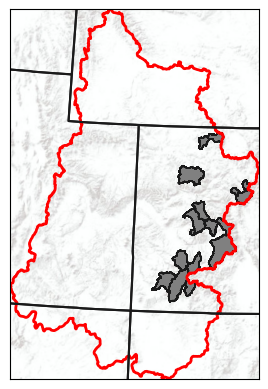

In [264]:
# # # subregion of the original image 1
x1, y1, x2, y2 = ucrb_basin_boundary.total_bounds
# inset axes....
fig, axins = plt.subplots()
ucrb_hcdn_basins_rpj.geometry.plot(ax=axins,color='grey',ec='k')
ucrb_basin_boundary.boundary.plot(ax=axins, lw=2,color='red')
western_states.boundary.plot(ax=axins, color='k')
# river_traces.plot(ax=axins, color='blue')
cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain, attribution='')
# subregion of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(bottom=False, left=False)

(181936.9814590584, 461457.3118677341, 4118161.6868092977, 4556952.5356851285)

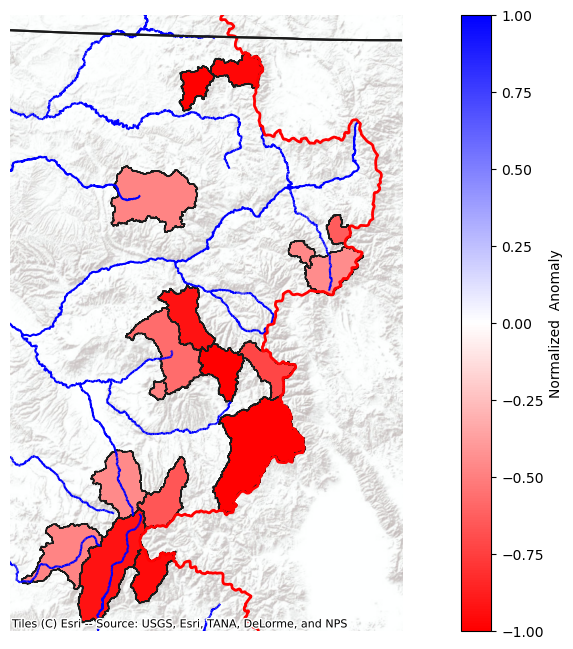

In [129]:
prism_anomaly_transpose = pd.read_csv('./UCRB_HCDN_CO_PRISM_ANNUAL_PRECIP.csv', index_col=0).T

fig, ax = plt.subplots(figsize=(15,8))

# ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
ucrb_hcdn_basins_rpj[year_to_plot] = prism_anomaly_transpose[year_to_plot_list].mean(axis=1).values
# To create full extent
extent = (ucrb_hcdn_basins_rpj_centroids.x.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.x.max()+4e4,
          ucrb_hcdn_basins_rpj_centroids.y.min()-4e4,
          ucrb_hcdn_basins_rpj_centroids.y.max()+4e4)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
ucrb_hcdn_basins_rpj.plot(column = year_to_plot, #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Normalized  Anomaly",},
                      missing_kwds ={'color':'darkgray'},
                      cmap='bwr_r',
                      vmin=-1,
                      vmax=1,
                      ec='k',
                      ax=ax) #Name the legend


river_traces.plot(ax=ax, color='blue')
ucrb_basin_boundary.boundary.plot(ax=ax, lw=2,color='red')
western_states.boundary.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain)

# # subregion of the original image 1
# x1, y1, x2, y2 = ucrb_basin_boundary.total_bounds
# # inset axes....
# axins = ax.inset_axes([0.7,0.7,0.3,0.3])
# ucrb_hcdn_basins_rpj.geometry.plot(ax=axins,color='grey',ec='k')
# ucrb_basin_boundary.boundary.plot(ax=axins, lw=2,color='red')
# western_states.boundary.plot(ax=axins, color='k')
# river_traces.plot(ax=axins, color='blue', alpha=0.5)
# cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Esri.WorldTerrain, attribution='')
# subregion of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins, edgecolor="black")


# Titles and Axis Labels
# ax.set_title(f'HCDN Basin Fall Soil Moisture Anomaly for WY{year_to_plot}\n(Missing values in grey)', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
# ax.legend()
ax.axis('off')




### Time series plots of SWE-Q residual, soil moisture anomalies, and precipitation anomalies

In [131]:
df_list = []
for site in norm_hcdn_streamflow.site_no.values:
    tmp=norm_hcdn_streamflow.sel(site_no=site)['00060_Mean'].to_dataframe()
    tmp = tmp.rename(columns={'00060_Mean':column_dict[site]})
    df_list.append(tmp[column_dict[site]])
norm_hcdn_streamflow_df = pd.concat(df_list, axis=1)        

NameError: name 'norm_hcdn_streamflow' is not defined

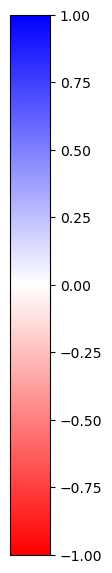

In [123]:
import pylab as pl
import numpy as np

a = np.array([[-1,1]])
pl.figure(figsize=(0.5, 9))
img = pl.imshow(a, cmap="bwr_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="vertical", cax=cax)
# pl.savefig("colorbar.pdf")

In [273]:
# Pull in precip anomalies
norm_prism_precip = pd.read_csv('./UCRB_HCDN_CO_PRISM_ANNUAL_PRECIP.csv', index_col='WY')
norm_et_hcdn = pd.read_csv('./HCDN_ET_ANOMALY_POINTS.csv', index_col='Unnamed: 0')
grace_ucrb = pd.read_csv('./grace/UCRB_GRACE_CORRECTED_FILTERED.csv',index_col='time')
grace_ucrb.index = pd.to_datetime(grace_ucrb.index)

In [269]:
from datetime import datetime, timedelta

(-10.0, 10.0)

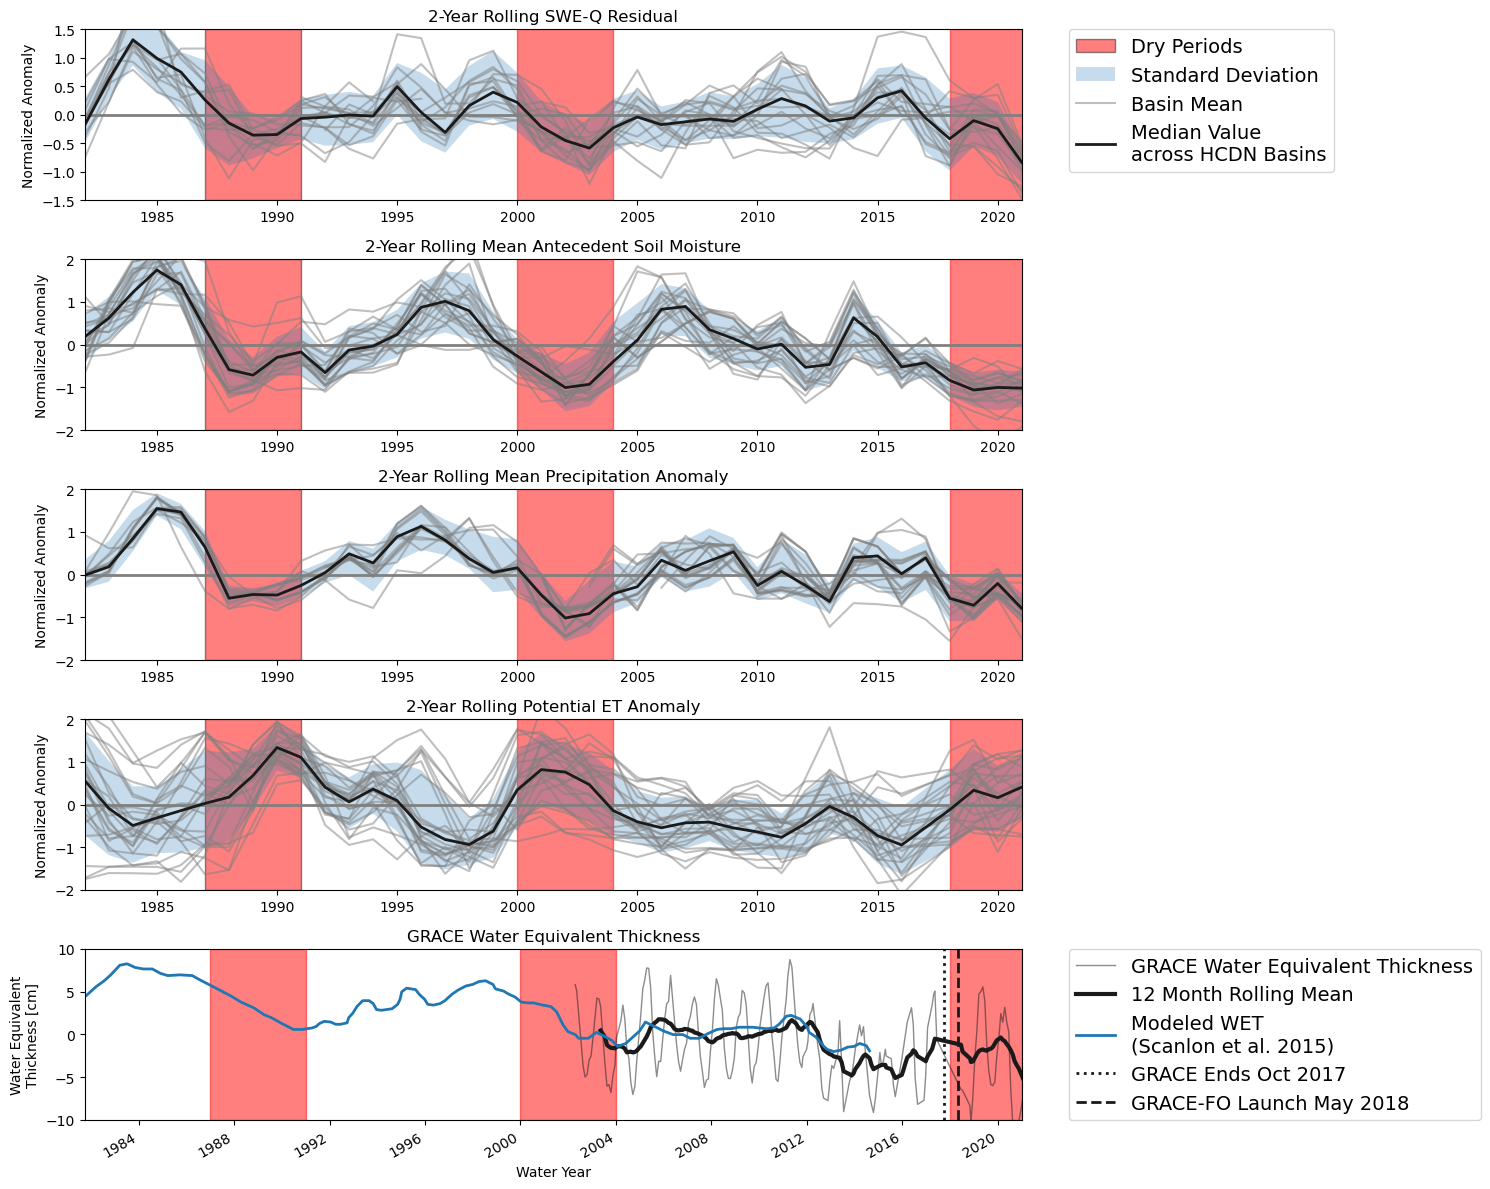

In [284]:
fig, axs = plt.subplots(nrows=5, figsize=(15,12), tight_layout=True)
for ax in axs:
    if ax != axs[4]:
        ax.axhline(0,color='grey', lw=2)
        ax.set_xlim(1982,2022)
        ax.set_ylabel('Normalized Anomaly')
        ax.axvspan(1987,1991,alpha=0.5, color='red', ec='k', label='Dry Periods')
        ax.axvspan(2000,2004,alpha=0.5, color='red')
        # ax.axvspan(2011,2015,alpha=0.5, color='red')
        ax.axvspan(2018,2022,alpha=0.5, color='red')
#################################
# Plot 0 - Streamflow
# ax=axs[0]
# ax.fill_between(x=norm_hcdn_streamflow_df.rolling(2).mean().index,
#                 y1=norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean()+norm_hcdn_streamflow_df.std(axis=1).rolling(2).mean(),
#                 y2=norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean()-norm_hcdn_streamflow_df.std(axis=1).rolling(2).mean(),
#                 alpha=0.25, 
#                 label='Standard Deviation',
#                 interpolate=True)

# # for col in norm_hcdn_streamflow_df.columns:
#     # ax.plot(norm_hcdn_streamflow_df[col].rolling(2).mean().index, norm_hcdn_streamflow_df[col].rolling(2).mean(),alpha=0.5)
# norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Mean Streamflow across HCDN Basins')
# ax.axhline(np.abs(((naturalized_flow-naturalized_flow.mean())/naturalized_flow.std()).loc[2002:2022].mean()).values[0], ls='--', color='r', lw=3, label='Historical Mean Naturalized LF\nStreamflow Compared to 2002-2022 Mean')
# ax.legend()
# ax.set_ylim(-2,2)
# ax.set_xlim(1982,2021)
# # ax.set_xlabel('Water Year')
# ax.set_title('2-Year Rolling Mean Apr-Sep Streamflow Anomaly')
#################################
# Plot 1 - SWE-Q residual
ax=axs[0]
ax.fill_between(x=residual_df.rolling(2).mean().index,
                y1=residual_df.mean(axis=1).rolling(2).mean()+residual_df.std(axis=1).rolling(2).mean(),
                y2=residual_df.mean(axis=1).rolling(2).mean()-residual_df.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in residual_df.columns:
    ax.plot(residual_df[col].rolling(2).mean().index, residual_df[col].rolling(2).mean(),alpha=0.5,color='grey')
ax.plot([],[],alpha=0.5,color='grey', label='Basin Mean')
residual_df.median(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Median Value\nacross HCDN Basins')
ax.legend(ncols=1, bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0., fontsize=14)
ax.set_ylim(-1.5,1.5)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling SWE-Q Residual')
#################################
# Plot 2 - Soil Moisture Anomaly
ax=axs[1]
ax.fill_between(x=hcdn_fall_soil_moisture_anomaly.rolling(2).mean().index,
                y1=hcdn_fall_soil_moisture_anomaly.mean(axis=1).rolling(2).mean()+hcdn_fall_soil_moisture_anomaly.std(axis=1).rolling(2).mean(),
                y2=hcdn_fall_soil_moisture_anomaly.mean(axis=1).rolling(2).mean()-hcdn_fall_soil_moisture_anomaly.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in hcdn_fall_soil_moisture_anomaly.columns:
    ax.plot(hcdn_fall_soil_moisture_anomaly[col].rolling(2).mean().index, hcdn_fall_soil_moisture_anomaly[col].rolling(2).mean(),alpha=0.5,color='grey')
hcdn_fall_soil_moisture_anomaly.median(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Median Anomaly across HCDN Basins')
# ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Mean Antecedent Soil Moisture')
#################################
# Plot 3 - Precipitation Anomaly
ax=axs[2]
ax.fill_between(x=norm_prism_precip.rolling(2).mean().index,
                y1=norm_prism_precip.mean(axis=1).rolling(2).mean()+norm_prism_precip.std(axis=1).rolling(2).mean(),
                y2=norm_prism_precip.mean(axis=1).rolling(2).mean()-norm_prism_precip.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in norm_prism_precip.columns:
    ax.plot(norm_prism_precip[col].rolling(2).mean().index, norm_prism_precip[col].rolling(2).mean(),alpha=0.5,color='grey')
norm_prism_precip.median(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label=' Precipitation Anomaly across HCDN Basins')
# ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
ax.set_xlabel('')
ax.set_title('2-Year Rolling Mean Precipitation Anomaly')
#################################
# Plot 4 - ET Anomaly
ax=axs[3]
ax.fill_between(x=norm_et_hcdn.rolling(2).mean().index,
                y1=-norm_et_hcdn.mean(axis=1).rolling(2).mean()+norm_et_hcdn.std(axis=1).rolling(2).mean(),
                y2=-norm_et_hcdn.mean(axis=1).rolling(2).mean()-norm_et_hcdn.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in norm_et_hcdn.columns:
    ax.plot(norm_et_hcdn[col].rolling(2).mean().index, -norm_et_hcdn[col].rolling(2).mean(),alpha=0.5,color='grey')
(-norm_et_hcdn.median(axis=1).rolling(2).mean()).plot(ax=ax, lw=2, color='k', label='Mean Anomaly\nacross HCDN Basins')
# ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Potential ET Anomaly')
#################################
# Plot 5 - GRACE WET Change
ax=axs[4]

grace_model = pd.read_csv('./grace/grace_scanlon_model_TWSe.csv', index_col=0).sort_index()
grace_model.index = [datetime(int(date), 1, 1) + timedelta(days = (date % 1) * 365) for date in grace_model.index ]
ax.axvspan(dt.date(1987,1,1),dt.date(1991,1,1),alpha=0.5, color='red')
ax.axvspan(dt.date(2000,1,1),dt.date(2004,1,1),alpha=0.5, color='red')
ax.axvspan(dt.date(2018,1,1),dt.date(2021,1,1),alpha=0.5, color='red')
# ax.axvspan(dt.date(2004,1,1),dt.date(2010,1,1),alpha=0.5, color='blue', label='Time-mean baseline')
ax.axvline()
# ax.axvspan(dt.date(2017,1,1),dt.date(2023,1,1),alpha=0.5, color='red')
grace_ucrb['lwe_thickness'].plot(ax=ax, lw=1, color='k', label='GRACE Water Equivalent Thickness', alpha=0.5)
grace_ucrb['lwe_thickness'].rolling(12).mean().plot(ax=ax, lw=3, color='k', label='12 Month Rolling Mean')
ax.plot(grace_model.index, (grace_model/5 + 3), label='Modeled WET\n(Scanlon et al. 2015)', lw=2)
ax.axvline(dt.date(2017,10,1), color='k', lw=2, ls='dotted', label='GRACE Ends Oct 2017',)
ax.axvline(dt.date(2018,5,1), color='k', lw=2, ls='--', label='GRACE-FO Launch May 2018')
ax.legend(ncols=1, bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0., fontsize=14)
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)
ax.set_xlim(dt.date(1981,10,1),dt.date(2021,1,1))
ax.set_xlabel('Water Year')
ax.set_title('GRACE Water Equivalent Thickness')
ax.set_ylabel('Water Equivalent\nThickness [cm]')
ax.set_ylim(-10,10)





### Same Plot with High and Low BFI basins

In [ ]:
high_bfi = ['09035900',    
'09047700',    
'09107000',    
'09115500',    
'09119000',    
'09146200',    
'09304500',    
'09361500']    

### Groundwater

In [290]:
ucrb_swb_model = pd.read_csv('../../data/800m_4km_10pc_runoff_monthly_SUMS_m3.txt', sep='\s+')

In [291]:
ucrb_gw_model_results = ucrb_gw_model_results = ucrb_swb_model[(ucrb_swb_model['SWB_Model_Run'].str.contains('RECHARGE'))]
ucrb_gw_model_results['myDt'] = ucrb_gw_model_results.apply(lambda row: dt.datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{1}", '%Y-%m-%d'), axis=1)
ucrb_gw_model_results = ucrb_gw_model_results.set_index('myDt', drop=True)
ucrb_gw_model_results['WY'] = ucrb_gw_model_results.index.year.where(ucrb_gw_model_results.index.month < 10, ucrb_gw_model_results.index.year + 1)
ucrb_gw_model_results

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_6884\101151172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucrb_gw_model_results['myDt'] = ucrb_gw_model_results.apply(lambda row: dt.datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{1}", '%Y-%m-%d'), axis=1)


SWB_Model_Run  Year  Month  \
myDt                                                                         
1981-01-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  1981      1   
1981-02-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  1981      2   
1981-03-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  1981      3   
1981-04-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  1981      4   
1981-05-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  1981      5   
...                                                       ...   ...    ...   
2014-08-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  2014      8   
2014-09-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  2014      9   
2014-10-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  2014     10   
2014-11-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  2014     11   
2014-12-01  UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...  2014     12   

            Parameter_Sum_m3    WY  
myDt                                
1981-01-01      1.401909e+08  1981  
1981-02-01      9.443194e+07  1981  
1981-03-01      1.116770e+08  1981  
1981-04-01      2.564375e+09  1981  
1981-05-01      1.418298e+09  1981  
...                      ...   ...  
2014-08-01      4.445419e+07  2014  
2014-09-01      1.143063e+08  2014  
2014-10-01      9.649352e+07  2015  
2014-11-01      4.865242e+07  2015  
2014-12-01      6.942441e+07  2015  

[408 rows x 5 columns]

In [292]:
gw_well_dtw = []
for file in os.listdir('./groundwater_data/'):
    tmp = pd.read_csv(f'./groundwater_data/{file}')
    well_name=list(tmp['Well Name'].unique())[0]

    # if 'WS-06A' in file:
    tmp.index = pd.to_datetime(tmp['Date'])
    tmp = tmp[tmp.index>dt.datetime(1985,10,1)]
    tmp['WY'] = tmp.index.year.where(tmp.index.month < 10, tmp.index.year + 1)
    df_annual = tmp.groupby(tmp.WY).mean()
    df_annual['Date'] = df_annual.apply(lambda row: dt.datetime.strptime(f"{(row.name)}-{1}-{1}", '%Y-%m-%d'), axis=1)
    df_annual=df_annual.reset_index(drop=True)
    df_annual[well_name] = -(df_annual['Depth to Water (ft)'] - df_annual['Depth to Water (ft)'].mean())/df_annual['Depth to Water (ft)'].std()
    gw_well_dtw.append(df_annual[['Date',well_name]])
    # else:
    #     tmp[well_name] = -(tmp['Depth to Water (ft)'] - tmp['Depth to Water (ft)'].mean())/tmp['Depth to Water (ft)'].std()
    #     tmp = tmp[np.abs(tmp[well_name])<4 ]
    #     gw_well_dtw.append(tmp[['Date',well_name]])

In [293]:
gw_well_dtw_df = pd.concat(gw_well_dtw,axis=0)
gw_well_dtw_df.index = pd.to_datetime(gw_well_dtw_df.Date)

Text(0, 0.5, 'Normalized Depth to Water')

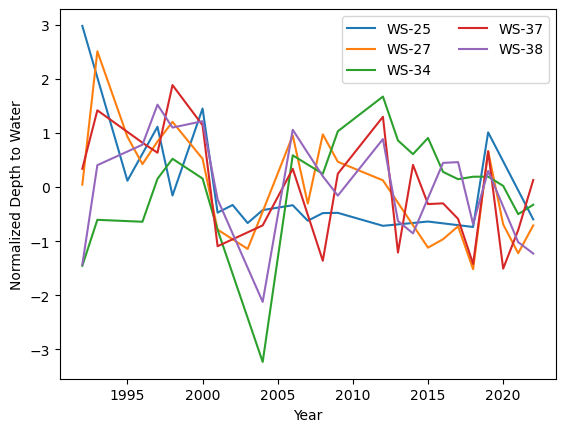

In [294]:
for col in gw_well_dtw_df.columns:
    if col not in ['Date','WS-06A','WS-43']:
        to_plot = gw_well_dtw_df[col].dropna()
        to_plot.groupby(to_plot.index.year).mean().plot()
plt.legend(ncol=2)
plt.xlabel('Year')
plt.ylabel('Normalized Depth to Water')

In [1]:
fig, axs = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True, sharex=True)
# Plot UCRB subbasin means and standard deviations for each year from model output with RCP 4.5 1950-2099 
wy_mean = ucrb_gw_model_results['Parameter_Sum_m3'].groupby(ucrb_gw_model_results['WY']).mean()

((wy_mean-wy_mean.mean())/wy_mean.std()).plot(ax=axs[0],
                                              label='SWB Modeled Recharge\n(1981-2014)',
                                              lw=2)
axs[0].plot([],[], label='GRACE Water Equivalent Thickness\n (mean CSR and JPL) (2003-2022)',color='orange')

# Plot Grace satellite data
grace_model = pd.read_csv('./grace_scanlon_model_TWSe.csv', index_col=0).sort_index()
grace_model.index = [dt.datetime(int(date), 1, 1) + dt.timedelta(days = (date % 1) * 365) for date in grace_model.index ]
ax.plot(grace_model.index, (grace_model/5 + 3), label='Modeled WET (Scanlon et al. 2015)', lw=2)
grace_data = pd.read_csv('timeseries_water_GRACE.csv', index_col=0)
grace_data.index = pd.to_datetime(grace_data.index)
grace_data['WY'] = grace_data.index.year.where(grace_data.index.month<10, grace_data.index.year+1)
grace_data = grace_data.groupby(grace_data.WY).mean().drop([2002,2023])
ax2=axs[0].twinx()
for col in grace_data:
    grace_data[f'{col[-13:-1]}_norm'] = (grace_data[col])
grace_data[['GRACE-FO JPL_norm','GRACE-FO CSR_norm']].mean(axis=1).plot(ax=ax2, 
                                                                        lw=2,
                                                                        color='orange')
ax2.set_ylim(-8,8)                                        
# For drought severity index
# drought_severity_index = pd.read_json('./dm_export_19871001_20220930_2.json')
# drought_severity_index.index = pd.to_datetime(drought_severity_index.ValidStart)
# drought_severity_index = drought_severity_index.sort_index()
# drought_severity_index['WY'] = drought_severity_index.index.year.where(drought_severity_index.index.month<10,drought_severity_index.index.year+1)
# plt_drought=(drought_severity_index.groupby('WY').mean()[['D1','D2','D3','D4']].sum(axis=1)>50).replace({False:np.nan}).dropna().index
# for year in plt_drought:
#     ax.fill_between([year, year+1], -2,2, alpha=0.5, color='red')
axs[0].axhline(0, color='k', ls='--', lw=2)
axs[0].set_ylabel('Normalized SWB Modeled Recharge', size=12)
ax2.set_ylabel('GRACE Water Equivalent Thickness [cm]', size=12)
axs[0].legend()
axs[0].set_ylim(-2,2)
axs[0].set_xlim(1979,2022)
# axs[0].set_xticks(ticks=np.arange(1981,2023,2));
# axs[0].set_xticklabels(labels=np.arange(1981,2023,2),rotation=45);
axs[0].set_title('UCRB SWB Groundwater Model Results (1980-2014) and\nGRACE Water Equivalent Thickness')

# Water level plots 
for col in gw_well_dtw_df.columns:
    if col not in ['Date','WS-06A', 'WS-43']:
        to_plot = gw_well_dtw_df[gw_well_dtw_df.index.year>=1990][col].dropna()
        to_plot.groupby(to_plot.index.year).mean().plot(ax=axs[1])
axs[1].axhline(0, color='k', ls='--', lw=2)
axs[1].set_ylim(-3,3)
axs[1].set_xlim(1979,2022)
axs[1].legend(loc='lower left')
axs[1].set_xlabel('Water Year', size=12)
axs[1].set_ylabel('Normalized Depth to Groundwater')
axs[1].set_title('UCRB DWR Well Depth to Water')

NameError: name 'plt' is not defined

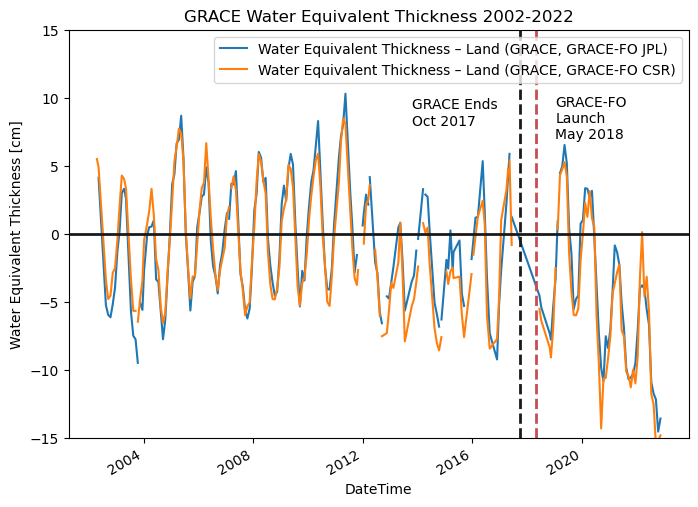

In [379]:
fig, ax = plt.subplots(figsize=(8,6))
grace_data = pd.read_csv('timeseries_water_GRACE.csv', index_col=0)
grace_data.index = pd.to_datetime(grace_data.index)
grace_data.plot(ax=ax)
grace_data['WY'] = grace_data.index.year.where(grace_data.index.month<10, grace_data.index.year+1)
ax.axvline(dt.date(2017,10,1), color='k', lw=2, ls='--')
ax.axvline(dt.date(2018,5,1), color='r', lw=2, ls='--')
ax.text(x=dt.date(2013,10,15),y=8,s='GRACE Ends\nOct 2017',)
ax.text(x=dt.date(2019,1,15),y=7,s='GRACE-FO\nLaunch\nMay 2018')
ax.set_ylabel('Water Equivalent Thickness [cm]')
ax.set_title('GRACE Water Equivalent Thickness 2002-2022')
ax.set_ylim(-15,15)
ax.axhline(0,color='k',lw=2)

(-15.0, 15.0)

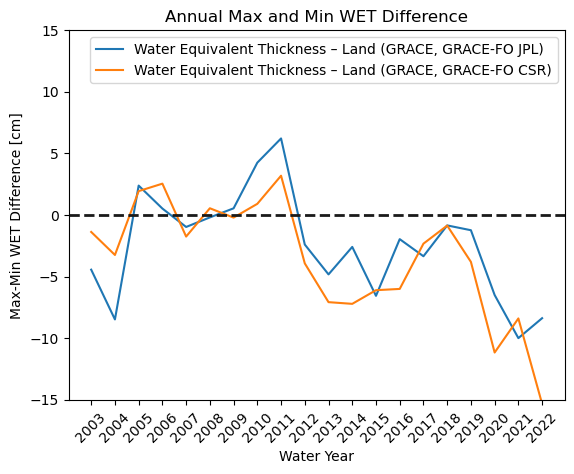

In [382]:
fig, ax = plt.subplots()
# grace_data.groupby(grace_data['WY']).max().plot(ax=ax)
# grace_data.groupby(grace_data['WY']).min().plot(ax=ax)
(np.abs(grace_data.groupby(grace_data['WY']).max().drop([2002,2023]))-np.abs(grace_data.groupby(grace_data['WY']).min().drop([2002,2023]))).plot(ax=ax)
ax.axhline(0,lw=2,color='k',ls='--')
ax.set_xticks(np.arange(2003,2023,1))
ax.set_xticklabels(np.arange(2003,2023,1), rotation=45);
ax.set_ylabel('Max-Min WET Difference [cm]')
ax.set_xlabel('Water Year')
ax.set_title('Annual Max and Min WET Difference')
ax.set_ylim(-15,15)

In [809]:
well_locs={
    'WS-25':{'lat':37.161107,
             'lon':-107.315298},
    'WS-27':{'lat':38.934691,
             'lon':-107.767157},
    'WS-34':{'lat':39.490665,
             'lon':-107.865712},
    'WS-37':{'lat':39.452551,
             'lon':-107.767157},
    'WS-38':{'lat':39.444236,	
             'lon':-108.390048},
    # 'WS-43':{'lat':37.159519,	
    #          'lon':-107.678339},
}

In [810]:
well_loc_df = pd.DataFrame.from_dict(well_locs,orient='index')
well_loc_gdf = gpd.GeoDataFrame(well_loc_df,
                                geometry=gpd.points_from_xy(well_loc_df.lon,well_loc_df.lat),
                                crs='4326'
                                )
well_loc_gdf = well_loc_gdf.to_crs('32613')

In [132]:
landsat_ndvi = pd.read_csv('./landsat/ee-chart.csv').dropna()
landsat_ndvi.index =  pd.to_datetime(landsat_ndvi['system:time_start'])

landsat_ndvi_2 = pd.read_csv('./landsat/ee-chart_hotchiss.csv').dropna()
landsat_ndvi_2.index =  pd.to_datetime(landsat_ndvi_2['system:time_start'])

landsat_ndvi_3 = pd.read_csv('./landsat/ee-chart_dryriparian.csv').dropna()
landsat_ndvi_3.index =  pd.to_datetime(landsat_ndvi_3['system:time_start'])

landsat_ndvi_ucrb = pd.read_csv('./landsat/ee-chart_ucrb.csv').dropna()
landsat_ndvi_ucrb.index =  pd.to_datetime(landsat_ndvi_ucrb['system:time_start'])

Text(0, 0.5, 'NDVI')

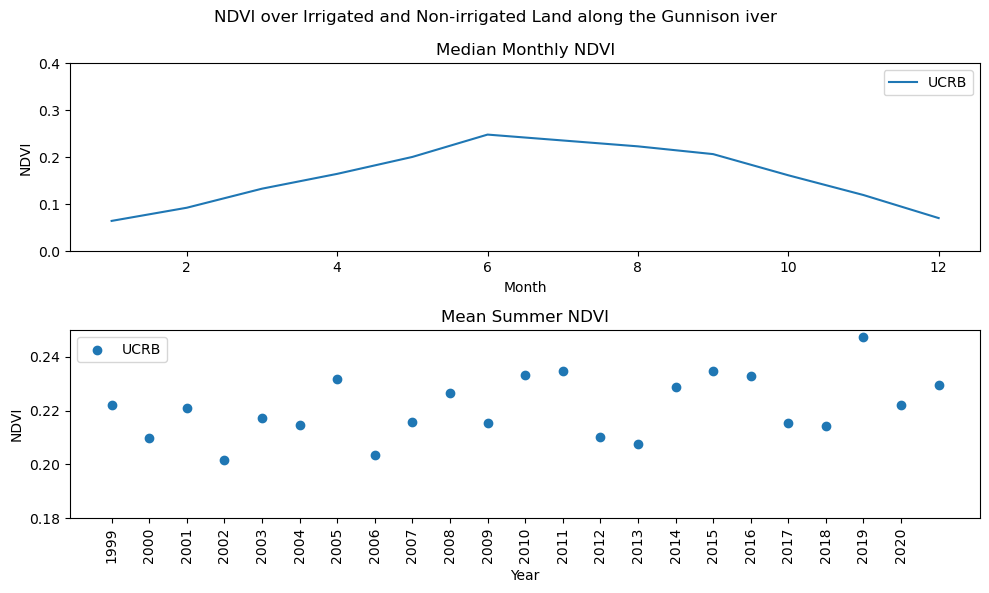

In [154]:
summer_landsat_ndvi = landsat_ndvi[landsat_ndvi.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_2 = landsat_ndvi_2[landsat_ndvi_2.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_3 = landsat_ndvi_3[landsat_ndvi_3.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_ucrb = landsat_ndvi_ucrb[landsat_ndvi_ucrb.index.month.isin([7,8,9])]['NDVI']
fig, [ax1,ax2] = plt.subplots(2, tight_layout=True, figsize=(10,6))
fig.suptitle('NDVI over Irrigated and Non-irrigated Land along the Gunnison iver')

# landsat_ndvi['NDVI'].groupby(landsat_ndvi.index.month).median().plot(ax=ax1, label='Gunnison (Irrigated Zone 1 - 5800 ft)')
# landsat_ndvi_2['NDVI'].groupby(landsat_ndvi_2.index.month).median().plot(ax=ax1, label='NF Gunnison (Irrigated Zone 2 - 5700 ft)')
# landsat_ndvi_3['NDVI'].groupby(landsat_ndvi_3.index.month).median().plot(ax=ax1, label='Gunnison (Non-Irrigated Zone 1 - 7600 ft)')
landsat_ndvi_ucrb['NDVI'].groupby(landsat_ndvi_ucrb.index.month).median().plot(ax=ax1, label='UCRB')
ax1.set_title('Median Monthly NDVI')
ax1.legend()
ax1.set_xlabel('Month')
ax1.set_ylabel('NDVI')
ax1.set_ylim(0.0,0.4)

# summer_landsat_ndvi.groupby(summer_landsat_ndvi.index.year).mean().plot(ax=ax2, label='Gunnison (Irrigated Zone 1 - 5800 ft)')
# summer_landsat_ndvi_2.groupby(summer_landsat_ndvi_2.index.year).mean().plot(ax=ax2, label='NF Gunnison (Irrigated Zone 2 - 5700 ft)')
# summer_landsat_ndvi_3.groupby(summer_landsat_ndvi_3.index.year).mean().plot(ax=ax2, label='Gunnison (Non-Irrigated Zone 1 - 7600 ft)')
fit  = np.polyfit(summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean().index,summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean(), deg =1)
ax2.scatter(summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean().index,summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean(), label='UCRB')


ax2.legend(loc='upper left')
ax2.set_title('Mean Summer NDVI')
ax2.set_xticks(np.arange(1999,2021,1))
ax2.set_ylim(0.18,0.25)
ax2.set_xticklabels(labels=np.arange(1999,2021,1), rotation=90)
ax2.set_xlabel('Year')
ax2.set_ylabel('NDVI')